In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def coth(a):
    if a>0: return (1+tf.math.exp(-2*a))/(1-tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)+1)/(tf.math.exp(2*a)-1)
    if a==0: return 0

def tanh(a):
    if a>0: return (1-tf.math.exp(-2*a))/(1+tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)-1)/(tf.math.exp(2*a)+1)
    if a==0: return 0

In [3]:
data=10000
batch=100
set=100
layer=10
n_ini=1.0
n_fin=0.1
dn=-0.1
c_reg1=0.015
c_reg2=0.0001
d=2

m^2= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.4494041790495995>
lam= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.3048807769816112>
alpha= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.008681764916513512>
beta= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.2296002504653344>
<tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([ 1.66024573,  0.6483396 ,  1.34097585,  3.06431094,  1.63789127,
       -0.7715394 ,  0.89577119,  2.48954403,  2.76482891,  0.96258756])>


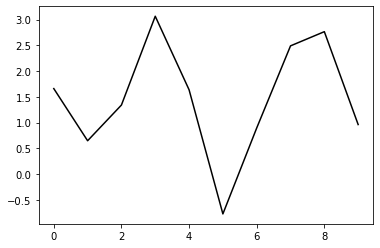

In [4]:
h=tf.zeros(layer)
h_in=[]
for i in range (layer):
    h_inn=np.float64(np.random.normal(2, 1))
    h_in.append(h_inn)
h=tf.Variable(h_in)
m2=tf.Variable(np.float64(np.random.normal(2, 1)))
lam=tf.Variable(np.float64(np.random.normal(1, 1)))
alpha=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
beta=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
#m2=tf.constant(np.float64(5.6))
#lam=tf.constant(np.float64(0.61))
#alpha=tf.constant(np.float64(1.444635))
#beta=tf.constant(np.float64(0.00615))
print("m^2=", m2)
print("lam=", lam)
print("alpha=", alpha)
print("beta=", beta)
print(h)
plt.plot(h.numpy(), 'k-')
plt.show()

In [5]:
def F_func(m, la, a,b):
    return 2*b/n_fin-m*a-la*(a**3)

def t_func(a):
    return 0.5*(tf.math.tanh(100*(a-0.1))-tf.math.tanh(100*(a+0.1))+2)

In [6]:
x=[i*0.2 for i in range (30)]
y=[0.0, 0.018, 0.035, 0.053, 0.0715, 0.0895, 0.107, 0.125, 0.146, 0.1665, 0.1875, 0.2085, 0.229, 0.25, 0.265, 0.281, 0.296, 0.3115, 0.3275, 0.343, 0.3565, 0.385, 0.4375, 0.5, 0.6, 0.675, 0.735, 0.815, 0.865, 0.885]
y[:]=[2*v for v in y]
fp1 = np.polyfit(x, y, 15)
print(fp1)

[ 1.59046394e-05 -6.81729682e-04  1.31412795e-02 -1.50525136e-01
  1.14052774e+00 -6.02241647e+00  2.27455168e+01 -6.20704699e+01
  1.22166922e+02 -1.71187074e+02  1.66428955e+02 -1.07461552e+02
  4.28229887e+01 -9.20544914e+00  9.55260239e-01 -1.30911492e-04]


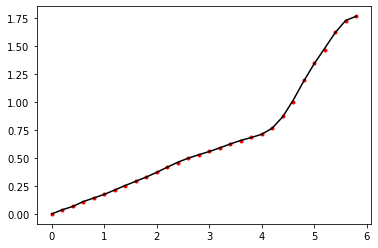

In [7]:
def f(x):
    y=0
    for i in range (16):
        y=y+fp1[i]*x**(15-i)
    return y
yy=[f(i*0.2) for i in range (30)]
plt.plot(x, y, 'r.')
plt.plot(x, yy, 'k-')
plt.show()

In [8]:
def NN_func_p(f):
    Positive=[]
    append=Positive.append
    while len(Positive)<batch:
        H=np.random.uniform(0.0, 6.0)
        M=np.random.uniform(0.0, 2.0)
        noise=np.abs(np.random.normal(0, 0.1))
        if np.abs(M-f(H))<=noise: append([H, M])
        else: continue
    return Positive
def NN_func_n(f):
    Negative=[]
    append=Negative.append
    while len(Negative)<batch:
        H=np.random.uniform(0.0, 6.0)
        M=np.random.uniform(0.0, 2.0)
        noise=np.abs(np.random.normal(0, 0.1))
        if np.abs(M-f(H))>noise: append([H, M])
        else: continue
    return Negative

In [9]:
Positive=[]
Negative=[]
for i in range (set):
    Positive.insert(i, NN_func_p(f))
    Negative.insert(i, NN_func_n(f))

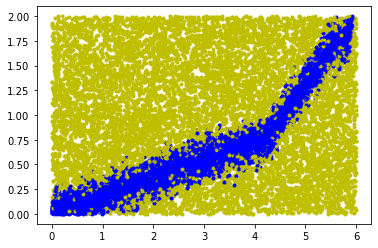

In [10]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive[i]])
    y_data1.insert(i, [v[1] for v in Positive[i]])
    x_data2.insert(i, [v[0] for v in Negative[i]])
    y_data2.insert(i, [v[1] for v in Negative[i]])
    plt.plot(x_data2[i], y_data2[i], 'y.')
    plt.plot(x_data1[i], y_data1[i], 'b.')
plt.show()

In [11]:
def Dfunc(hh, m):
    D=tf.math.sqrt(tf.math.abs(1+4*m/(hh[0]**2)))
    return D

In [12]:
def LP2(hh, m, la, alpha, beta, HH, MM):
    D=Dfunc(hh, m)
    phi=alpha*HH+beta*MM
    pi=(d/2)*(D-1)*alpha*HH+(d/2)*(-D-1)*beta*MM
    for j in range (layer-1):
        phi1=phi+dn*pi
        pi1 =phi*m*dn+(1-dn*hh[j])*pi+dn*la*(phi1**3)
        phi=phi1
        pi=pi1
    return phi, pi
def NN_func_01(hh, m, la, alpha, beta, list_hr):
    PP=[]
    NN=[]
    H=np.array(list_hr)[:, 0]
    M=np.array(list_hr)[:, 1]
    F=np.array(tf.math.abs(LP2(hh, m, la, alpha, beta, H, M)[1]))
    for i in range (len(H[F<0.1])):
        PP.append([H[F<0.1][i], M[F<0.1][i]])
    for i in range (len(H[F>=0.1])):
        NN.append([H[F>=0.1][i], M[F>=0.1][i]])
    return PP, NN

In [13]:
Positive0=[]
Positive1=[]
Negative0=[]
Negative1=[]
for i in range (set):
    Positive0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[0])
    Positive1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[1])
    Negative0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[0])
    Negative1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[1])

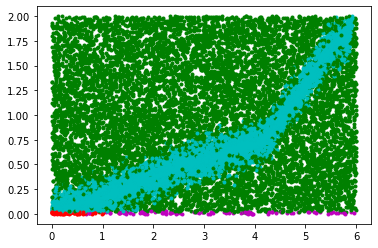

In [14]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
x_data3=[]
y_data3=[]
x_data4=[]
y_data4=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive0[i]])
    y_data1.insert(i, [v[1] for v in Positive0[i]])
    x_data2.insert(i, [v[0] for v in Positive1[i]])
    y_data2.insert(i, [v[1] for v in Positive1[i]])
    x_data3.insert(i, [v[0] for v in Negative0[i]])
    y_data3.insert(i, [v[1] for v in Negative0[i]])
    x_data4.insert(i, [v[0] for v in Negative1[i]])
    y_data4.insert(i, [v[1] for v in Negative1[i]])
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()

# Error function

$E=\sum_{data} \left\vert y(\bar{x}^{(1)}) - \bar{y} \right\vert+E_{reg}(W)$
, $E_{reg}=c_{reg}^{(1)}\sum_{n=1}^{N-1}(\eta^{(n)})^{4}(h(\eta^{(n+1)})-h(\eta^{(n)}))^{2}+c_{reg}^{(2)}(h(\eta^{(N)})-1/\eta^{(N)})^{2}$

In [15]:
def Error_func(hh, m, la, alpha, beta, list1, list2):
    H0=np.array([v[0] for v in list1])
    M0=np.array([v[1] for v in list1])
    H1=np.array([v[0] for v in list2])
    M1=np.array([v[1] for v in list2])
    H_0, M_0=LP2(hh, m, la, alpha, beta, H0, M0)
    H_1, M_1=LP2(hh, m, la, alpha, beta, H1, M1)
    PPlist=t_func(M_0)
    NNlist=t_func(M_1)
    sum_p=sum(PPlist)/batch
    sum_n=(batch-sum(NNlist))/batch

    inside=0
    for k in range (layer-1):
        second=((n_ini+k*dn)**4)*((hh[k+1]-hh[k])**2)
        inside=inside+second
    E_reg1=c_reg1*inside
    E_reg2=c_reg2*((hh[layer-1]-1/n_fin)**2)
    return sum_n+sum_p+E_reg1+E_reg2

In [16]:
for i in range (set):
    print(Error_func(h, m2, lam, alpha, beta, Positive[i], Negative[i]))

tf.Tensor(1.0687691800185926, shape=(), dtype=float64)
tf.Tensor(1.0585673323628118, shape=(), dtype=float64)
tf.Tensor(1.062554178056265, shape=(), dtype=float64)
tf.Tensor(1.051281360943997, shape=(), dtype=float64)
tf.Tensor(1.0615198816590081, shape=(), dtype=float64)
tf.Tensor(1.0669904793669864, shape=(), dtype=float64)
tf.Tensor(1.0784921131691605, shape=(), dtype=float64)
tf.Tensor(1.0687773665451248, shape=(), dtype=float64)
tf.Tensor(1.0887334804489406, shape=(), dtype=float64)
tf.Tensor(1.0956979085233085, shape=(), dtype=float64)
tf.Tensor(1.0383349807413895, shape=(), dtype=float64)
tf.Tensor(1.0699852882658996, shape=(), dtype=float64)
tf.Tensor(1.046735144185617, shape=(), dtype=float64)
tf.Tensor(1.0533335429788484, shape=(), dtype=float64)
tf.Tensor(1.0687773996920091, shape=(), dtype=float64)
tf.Tensor(1.0687771699532431, shape=(), dtype=float64)
tf.Tensor(1.0787673008025505, shape=(), dtype=float64)
tf.Tensor(1.0686799902935984, shape=(), dtype=float64)
tf.Tensor(1.0

# Optimize

0 1.062258499670391
1.4421610301388097 0.30464099157763475 -0.01703719172266853 0.22130762137605284
[ 1.6102467   0.69833893  1.39097193  3.01431188  1.68785858 -0.72154177
  0.84578676  2.4395696   2.71501886  1.01257191]


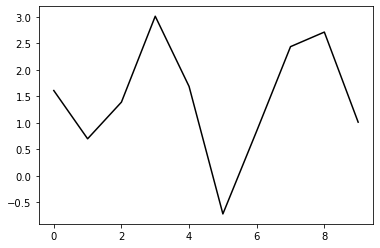

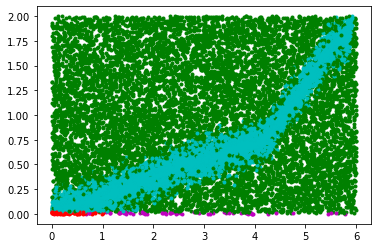

1000 0.8943516969002329
0.9771330331889337 0.23451687051044112 -0.01841392267098456 -0.06737586424984855
[ 1.25123715e+00  9.36931039e-01  7.67334683e-01  4.45310926e-01
  5.36047000e-03 -4.88905519e-01 -8.75744479e-01 -3.23414455e-01
  4.33460908e-01  5.56553073e+00]


2000 0.3563382271425942
0.9259767316986185 -0.2026712906136299 -0.08237543606248127 -0.07151007379883431
[ 0.9241848   0.97326753  0.84033532  0.56208994  0.10964713 -0.46909711
 -0.98097119 -0.7511626  -0.07822102  8.04460614]


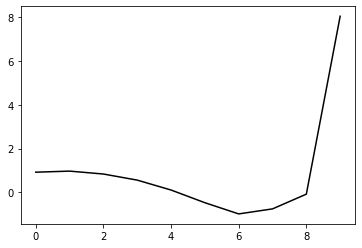

3000 0.1897809240797663
0.8106940216356882 -0.6797938265937745 -0.13090788919858296 -0.09695940039487193
[ 1.06018418  0.95976904  0.79316949  0.58136901  0.24451158 -0.25042806
 -0.75432005 -0.68408457  0.02446776  8.07066924]


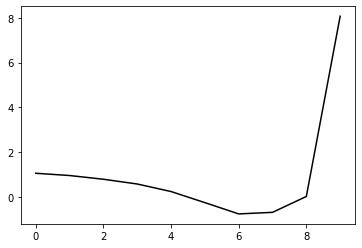

4000 0.26073787036832
0.764093519274638 -0.6995839537487469 -0.13518834847134648 -0.10649169847047436
[ 1.19318393  1.044724    0.91039117  0.71477341  0.43819096  0.0498435
 -0.39307009 -0.45784863  0.25191332  8.09853801]


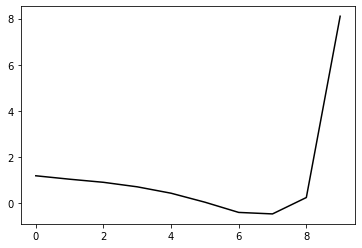

5000 0.29168960991909443
0.7256511062234984 -0.6953830795963297 -0.13416190427586197 -0.10391716433531328
[ 1.18791134  1.07681408  0.9746194   0.80696204  0.54431968  0.16445715
 -0.30861473 -0.58054906 -0.03623894  8.06201054]


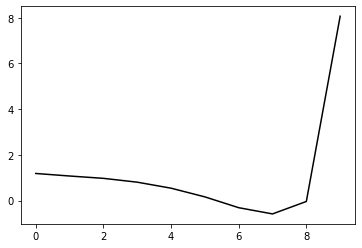

6000 0.2462225676263414
0.6972667680711137 -0.683627171706735 -0.13040618128643588 -0.10402705406111565
[ 1.1892671   1.14421729  1.08464146  0.95457015  0.73218275  0.38245973
 -0.0994452  -0.50984113 -0.1281939   8.02747347]


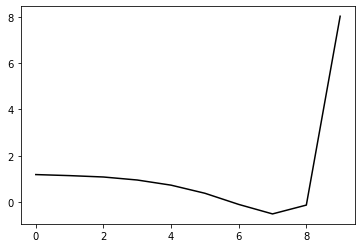

7000 0.16483724333473732
0.6580082380103143 -0.6815375858503544 -0.13208339270600714 -0.10082902183581094
[ 1.19341923e+00  1.14415411e+00  1.09714208e+00  9.96871824e-01
  8.09645013e-01  4.89266580e-01  8.35466188e-04 -5.26613412e-01
 -3.13206695e-01  7.98956982e+00]


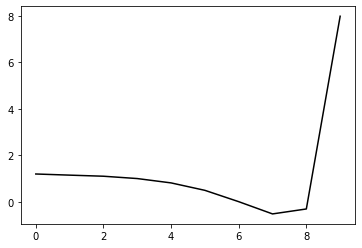

8000 0.12191350282851099
0.6266655587419464 -0.6747858353711715 -0.13169052560001807 -0.09745797077086658
[ 1.17067586  1.14699902  1.10648014  1.02711994  0.86772982  0.57191315
  0.08701775 -0.51028009 -0.4188619   7.94231817]


9000 0.19809691079748654
0.5905820317176109 -0.6681577819309795 -0.13050984073404878 -0.09673391726328887
[ 1.21314561  1.1930864   1.12555742  1.03135327  0.88238802  0.62407831
  0.18146339 -0.43047014 -0.43541909  7.95628404]


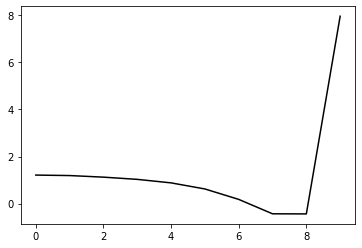

10000 0.236238351288637
0.5686151104824289 -0.6599736482489215 -0.13123638833231135 -0.09330405348397086
[ 1.2286501   1.21079068  1.19541465  1.14431517  1.02636748  0.78650267
  0.35084932 -0.29968605 -0.42990179  7.97574653]


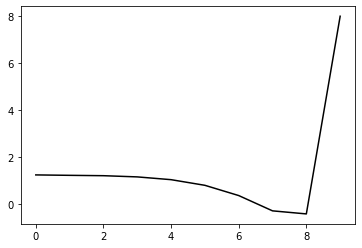

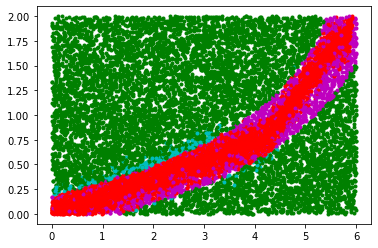

11000 0.22442838797614817
0.5439864164601613 -0.6489048808309233 -0.12816705915510768 -0.09352734360517205
[ 1.20591756  1.21933537  1.22490466  1.18779801  1.0744869   0.83237875
  0.38737871 -0.29948507 -0.53764572  7.94285741]


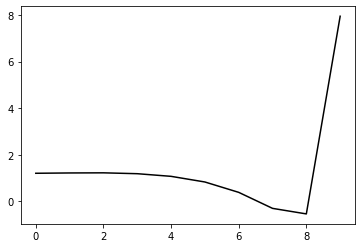

12000 0.20905160804125467
0.5187366931783175 -0.6425857642480357 -0.1280797503507983 -0.09237042718184502
[ 1.20217108  1.24206346  1.28197596  1.27280744  1.18566802  0.96428324
  0.5175354  -0.21367391 -0.57286079  7.98207218]


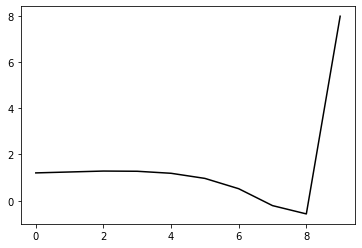

13000 0.1878390123565721
0.5006755994165547 -0.6359845449367935 -0.12780574264754405 -0.09296688275275815
[ 1.21053918  1.22204558  1.24648792  1.22811974  1.14981172  0.94956324
  0.52424739 -0.21165655 -0.64111359  7.92844149]


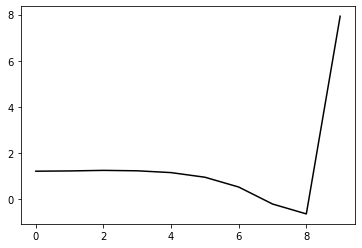

14000 0.19967387348621427
0.48355181225600397 -0.6315135014290951 -0.12882125994247348 -0.0906730381442987
[ 1.21032198  1.20500544  1.22057128  1.22126263  1.17032136  1.00070198
  0.60407565 -0.13089051 -0.6421463   7.93785099]


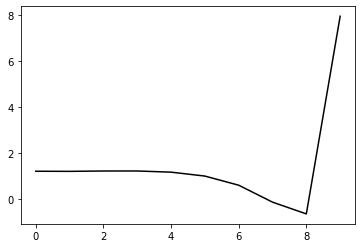

15000 0.3218493199134544
0.46880798636397003 -0.6218107682035989 -0.1270738197764753 -0.09360705680400161
[ 1.19505729  1.22472864  1.25208653  1.24236     1.17747158  0.99972735
  0.60356659 -0.14234672 -0.73204782  7.91915697]


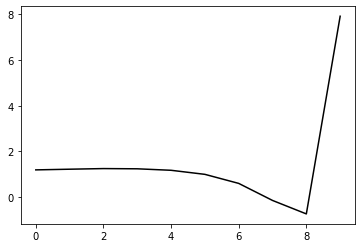

16000 0.31894945585267187
0.4693121172736655 -0.6092562428648342 -0.12498890625274121 -0.0954319412191449
[ 1.20826633  1.25593827  1.31692194  1.3375573   1.29860706  1.14648393
  0.77540443  0.04389081 -0.59665015  7.90956455]


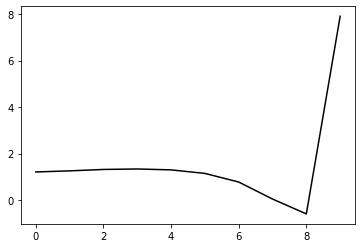

17000 0.19767780938312932
0.4544037427894652 -0.6062769258562043 -0.12915196831548795 -0.09161564133781709
[ 1.15424949e+00  1.21069582e+00  1.26519937e+00  1.27564738e+00
  1.23476552e+00  1.08619653e+00  7.24905479e-01  1.35466118e-03
 -6.82742302e-01  7.93180327e+00]


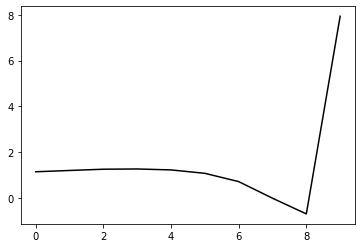

18000 0.19240103604594064
0.43104741433537086 -0.6022679105496959 -0.12836005455513144 -0.09368306685119729
[ 1.17301615  1.21539751  1.22907463  1.23227828  1.20232338  1.07648804
  0.74597182  0.05248068 -0.64910118  7.91357615]


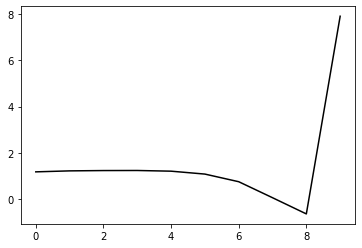

19000 0.22427357001325315
0.42365445244921385 -0.5959474217783528 -0.1290277297344664 -0.08962467650405183
[ 1.19847893  1.21588851  1.25513508  1.27529636  1.2465066   1.12546392
  0.81523005  0.15310275 -0.55808968  7.96510041]


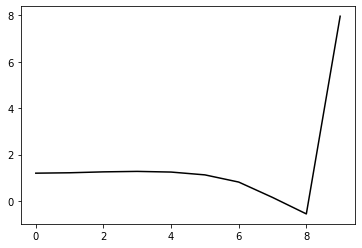

20000 0.17336436199444227
0.4210489326750878 -0.588773454259944 -0.12883964775505552 -0.0928806427418201
[ 1.13559405  1.25967799  1.31228057  1.31280658  1.25783012  1.10621062
  0.77392347  0.10672595 -0.62556815  7.92479399]


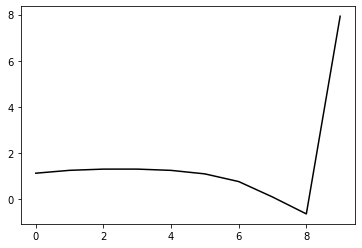

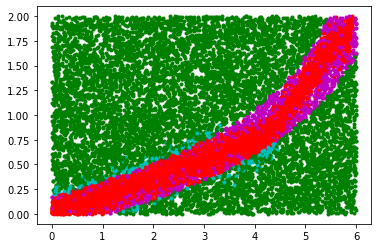

21000 0.16069754994453297
0.41493111589788734 -0.5791300953607412 -0.1272441263818435 -0.09476187625151812
[ 1.16353472  1.21136566  1.24938872  1.26221629  1.23105811  1.10668362
  0.79842504  0.15838227 -0.56275966  7.97059785]


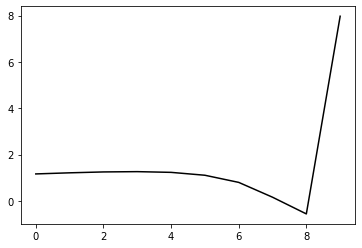

22000 0.3381066860823734
0.408096215897556 -0.5697724555772896 -0.12545130759015302 -0.09727791654595128
[ 1.18240626  1.19023802  1.24972945  1.27056609  1.25235863  1.1581817
  0.89158942  0.29559464 -0.39850212  7.96405191]


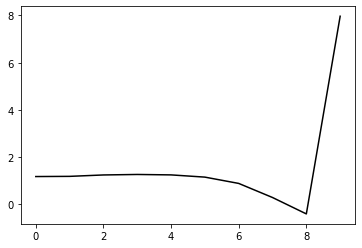

23000 0.21998074558198885
0.39326786948561865 -0.5673499216468111 -0.12852929711845734 -0.09597596206729801
[ 1.13320628  1.15379529  1.21110251  1.2411145   1.20579149  1.07787706
  0.78525585  0.18211858 -0.52133496  7.95486929]


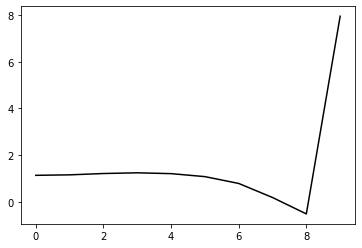

24000 0.2593730214364779
0.3839805135787893 -0.5587713879870065 -0.12691585587171422 -0.0961610712272455
[ 1.16550965  1.15278354  1.14904416  1.15409945  1.12361902  1.01100157
  0.7337654   0.15069338 -0.53048341  7.96163853]


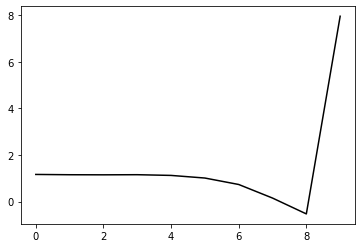

25000 0.18762827255304912
0.386834071908471 -0.5523858513028516 -0.1303351309013038 -0.09520426496523644
[ 1.14526058  1.18149301  1.19791037  1.19210878  1.14306384  1.01524698
  0.73053337  0.14881111 -0.52893296  7.95823436]


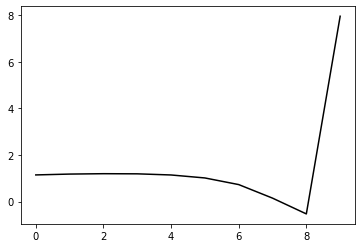

26000 0.26776611335287265
0.3852804687303437 -0.5411019944890644 -0.12756037458671413 -0.09663861579658399
[ 1.16542768  1.1949768   1.27723695  1.30317832  1.27483337  1.16739524
  0.89965318  0.33688284 -0.32087888  7.98395784]


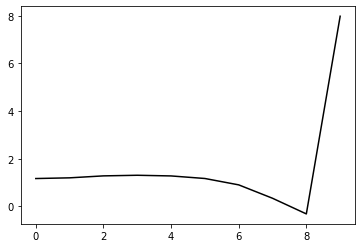

27000 0.29139297719377494
0.37830827860299965 -0.5379333672332729 -0.13031867016230206 -0.0944792172953222
[ 1.16412915  1.10924545  1.16066585  1.19013491  1.15507538  1.02906389
  0.74387968  0.17362976 -0.47731327  7.94015806]


28000 0.19800946349077933
0.37078933022497057 -0.5349595564157476 -0.1341151700357317 -0.09076292492213178
[ 1.11813295e+00  1.07958604e+00  1.09741787e+00  1.10262731e+00
  1.05389023e+00  9.11234709e-01  6.01522214e-01  6.80133032e-03
 -6.58298073e-01  7.93380432e+00]


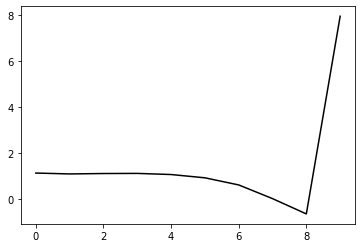

29000 0.14263257974852872
0.37131172503754534 -0.5267078352946686 -0.13358865675116155 -0.09703533435046369
[ 1.13851817  1.17849094  1.20773049  1.20519541  1.15205047  1.01229458
  0.70147071  0.09896675 -0.56760983  7.97410825]


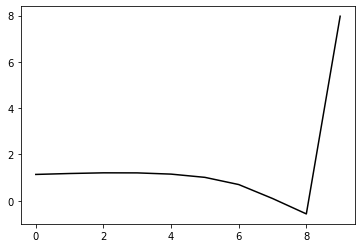

30000 0.1704647038995845
0.36346720178161074 -0.5211241046481175 -0.1339668821029361 -0.09633336098865433
[ 1.13827263  1.15747426  1.15186679  1.14914098  1.12309169  1.02393564
  0.75622612  0.18560921 -0.45472097  7.97213452]


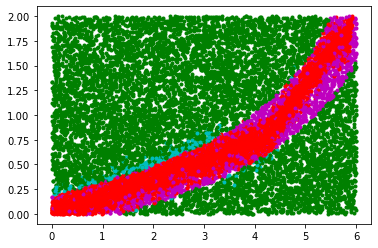

31000 0.27815437783965374
0.3636673844522257 -0.510261868019602 -0.13215027087432332 -0.09830419761003112
[ 1.13151916  1.14098407  1.19255711  1.19568145  1.14470612  1.01665545
  0.73312973  0.15509329 -0.49509148  7.96353737]


32000 0.2154474931177445
0.35573579973358405 -0.5075004322130674 -0.13497069731037184 -0.09647963821854995
[ 1.13954769  1.17329875  1.18373541  1.17776579  1.13889876  1.02008346
  0.74115607  0.17340764 -0.46378709  7.96259177]


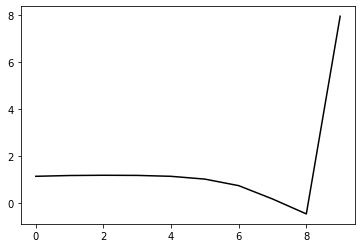

33000 0.2258526292269126
0.34510874220456544 -0.5017138619997021 -0.13440462102760248 -0.0964072751237606
[ 1.1264056   1.09320347  1.08434988  1.07541927  1.0297798   0.90768864
  0.62931013  0.06406266 -0.56987176  7.99332626]


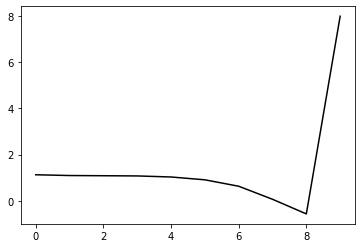

34000 0.2929332431593033
0.34548129108420006 -0.4870549000830215 -0.1302684526111083 -0.09575238220007407
[ 1.16501863  1.21082428  1.23312308  1.23339371  1.20497358  1.10228172
  0.83976234  0.28715377 -0.33926548  7.95192903]


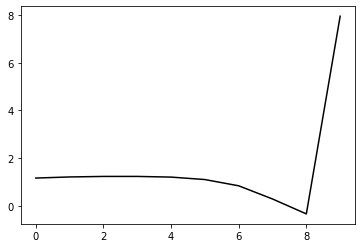

35000 0.1819849122718633
0.34659351740839783 -0.48423024986576707 -0.1348103032361661 -0.094731919099098
[ 1.14114914  1.14830576  1.20243471  1.2357038   1.21118953  1.09675943
  0.82710961  0.27872645 -0.33639825  8.00417036]


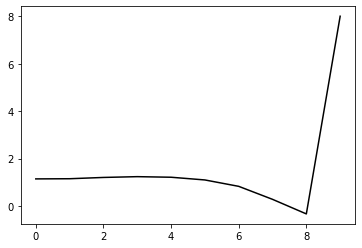

36000 0.3246889832193369
0.3442111704800937 -0.48039981942641113 -0.13679665264599775 -0.09389550511280381
[ 1.15414048  1.17081659  1.2291035   1.25235367  1.23510319  1.14378612
  0.89806006  0.3717924  -0.21714475  7.9854719 ]


37000 0.16726192191739275
0.33379954416677315 -0.4751093215925249 -0.13727641424885642 -0.09375719880852522
[ 1.14359122  1.15782587  1.18462145  1.18356487  1.15014944  1.05805796
  0.82312861  0.31344587 -0.25672781  7.98510347]


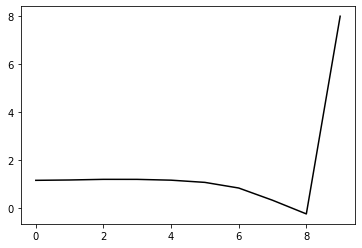

38000 0.30291504431097055
0.33613596713336386 -0.4658113893350901 -0.1353316897383038 -0.09797738276519466
[ 1.14409491  1.19394091  1.26014085  1.26462657  1.21303528  1.09540242
  0.84311034  0.33407452 -0.22265314  8.01862322]


39000 0.308601579393991
0.3377668316346902 -0.4585854411428821 -0.13464565705273338 -0.09804494001111562
[ 1.1556102   1.14718964  1.19075583  1.21938247  1.19777342  1.09907269
  0.85661487  0.3617648  -0.16980497  8.00971774]


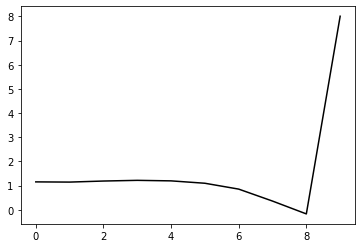

40000 0.22998999897046465
0.3302904373079169 -0.4591420224642409 -0.14026271406669905 -0.09381042101319101
[ 1.1217775   1.13581564  1.18807384  1.19880691  1.16040942  1.05286073
  0.80712103  0.30963454 -0.21545543  7.9943594 ]


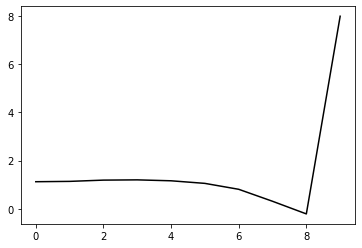

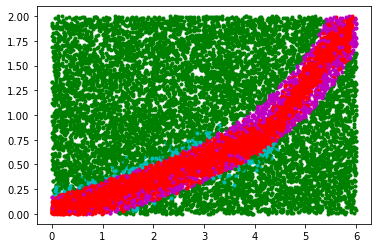

41000 0.2350413499710192
0.3315741574202724 -0.4509914984769726 -0.1398852561510017 -0.0926164342969093
[ 1.11166554  1.14134765  1.20541833  1.2218364   1.17263368  1.04316347
  0.77586964  0.26463644 -0.26213414  8.03953049]


42000 0.24695402799500968
0.3324398776125982 -0.44665538332396754 -0.14077299468934498 -0.09777235711979342
[ 1.12528356  1.21365969  1.31163851  1.3294451   1.27602961  1.14121606
  0.86086727  0.33685872 -0.18833465  8.00958215]


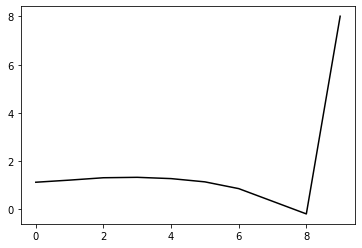

43000 0.21992553552547645
0.3187775014148722 -0.4443933834319426 -0.14120599157640285 -0.09734236277748445
[ 1.10470283  1.13446404  1.13541124  1.12548078  1.09093893  0.99145873
  0.74076074  0.23303085 -0.27129125  8.0206453 ]


44000 0.17354863970470827
0.32134577425708283 -0.43835476308102234 -0.14172020289796214 -0.096421437033149
[ 1.09705421  1.10588904  1.15233198  1.16475868  1.11791783  0.99095378
  0.72417935  0.21080212 -0.29123034  7.99222868]


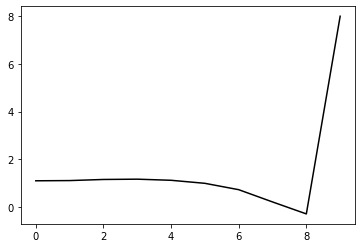

45000 0.16548836058747948
0.3163297885211174 -0.4332065168023837 -0.14260486122338656 -0.09889068006284284
[ 1.12320227  1.12585714  1.12216298  1.11518445  1.07577118  0.96139726
  0.70122266  0.193078   -0.29919791  8.02502316]


46000 0.24799990422011414
0.3186859541177732 -0.42626167352683203 -0.1424459141789696 -0.09825074536597875
[ 1.12668023  1.12248711  1.13504865  1.13506834  1.09725799  0.97743538
  0.70345304  0.17994314 -0.32086051  7.99292089]


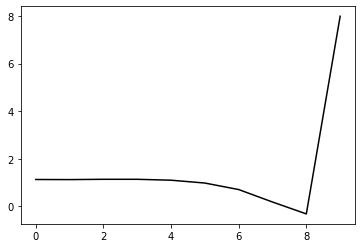

47000 0.16645098289188737
0.32139825411805983 -0.4186573128143708 -0.14244248885684355 -0.09899956934983359
[ 1.1281123   1.13415141  1.15536959  1.14785354  1.10432234  0.99357217
  0.73750443  0.22818847 -0.25780562  8.01048568]


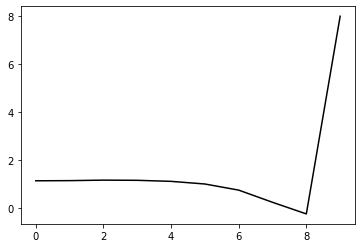

48000 0.1840129610038707
0.3188181517420038 -0.416074419585715 -0.14506237934100757 -0.09652030157045963
[ 1.11105441  1.12227707  1.16151596  1.16703915  1.12110608  1.00243046
  0.74307887  0.23404585 -0.25368387  8.00855916]


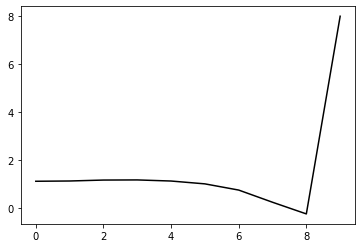

49000 0.18454431135156138
0.3061613454210582 -0.4154334843342897 -0.14737816070075782 -0.09570214369787738
[ 1.14041978  1.04079906  1.07576492  1.07189037  1.02014168  0.88941758
  0.60728877  0.075309   -0.43401228  7.95885282]


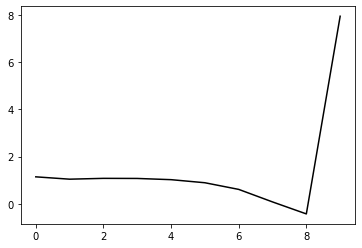

50000 0.17746096626604987
0.3066946979716361 -0.40747053157735447 -0.14616423765666045 -0.09964154313342807
[ 1.1334886   1.17656239  1.18686661  1.16497585  1.10468623  0.96934873
  0.68335052  0.14391546 -0.37151348  8.00349892]


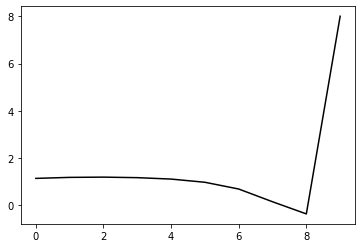

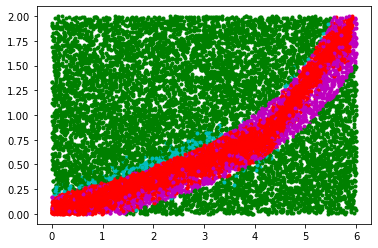

51000 0.14263552973417087
0.3058125708157648 -0.4005594428399991 -0.14513886155678177 -0.10161853170962709
[ 1.10917737  1.12593791  1.13897352  1.12142864  1.07403299  0.95010416
  0.6686372   0.1290744  -0.38541806  7.98045544]


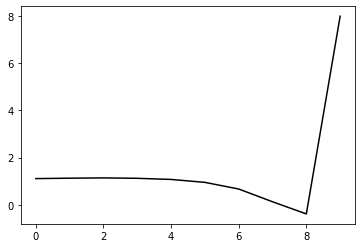

52000 0.2044573890145586
0.2986869031516238 -0.3972336425902119 -0.14606815792961053 -0.10141728002342129
[ 1.10128665  1.05926742  1.04021178  1.01771222  0.96541891  0.84344229
  0.56857884  0.03185723 -0.48264389  8.01212384]


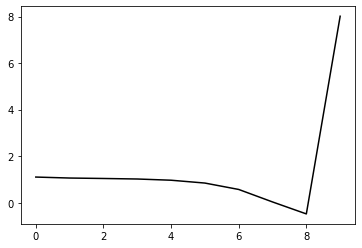

53000 0.15481756717050696
0.3029787606191356 -0.3934460629288552 -0.14895646480971314 -0.1026111696074756
[ 1.0906767   1.10304877  1.12027251  1.10742328  1.0634318   0.9552849
  0.70267385  0.19224889 -0.29721729  8.00676764]


54000 0.24483184324386953
0.29393800465307546 -0.3870321628770539 -0.14566445485591267 -0.10382385094874574
[ 1.10477111  1.03847826  0.96222486  0.92960513  0.88484139  0.77457739
  0.52049373  0.01463877 -0.46957078  7.96230661]


55000 0.1442605078380604
0.30479955040646306 -0.37982909621977484 -0.14647226078789044 -0.10385079361375008
[ 1.09092244  1.12459734  1.12980573  1.10780566  1.04517967  0.9083333
  0.63483478  0.12138385 -0.36421978  8.01094689]


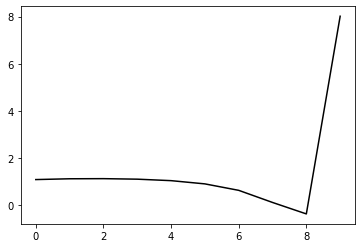

56000 0.2683277777450493
0.29832773973182114 -0.3810278524876425 -0.15024568203202723 -0.10387649948401038
[ 1.10243062  1.07069578  1.08134437  1.06603766  1.01629931  0.90653996
  0.66103567  0.17651845 -0.2754755   7.98507586]


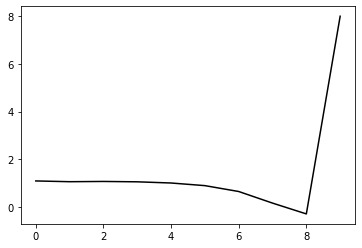

57000 0.2044596927995851
0.30234045116910074 -0.37117588379241373 -0.14795542004884868 -0.10391813390754484
[ 1.10555612  1.16520216  1.17509046  1.14310236  1.07273515  0.93996353
  0.67920899  0.19379489 -0.24765712  7.98887187]


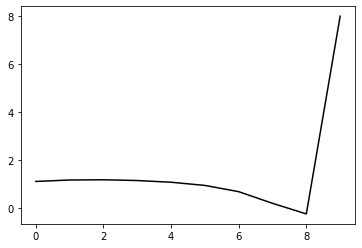

58000 0.14940213388015183
0.3000839118204122 -0.37426850869254474 -0.1540703616511731 -0.10157135347103215
[ 1.09000124  1.03913278  1.05357049  1.06058022  1.01720576  0.89170048
  0.63004942  0.15001056 -0.27236841  8.01316783]


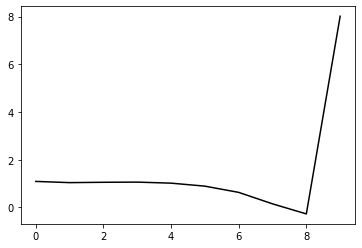

59000 0.25033888733367043
0.30263306692227027 -0.3657814611108145 -0.15293659274492616 -0.10050541612770934
[ 1.0897041   1.10807477  1.1144196   1.08151656  1.01454041  0.8840113
  0.62031848  0.13614918 -0.28024652  7.99395303]


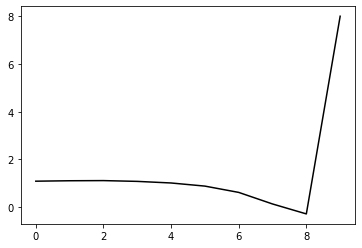

60000 0.24871114321766272
0.297716098593323 -0.36080387465620106 -0.1515592869853861 -0.10407519612608002
[ 1.11261893  1.11982942  1.11256603  1.09256058  1.0389517   0.91592661
  0.65388802  0.16739867 -0.24743566  8.02501293]


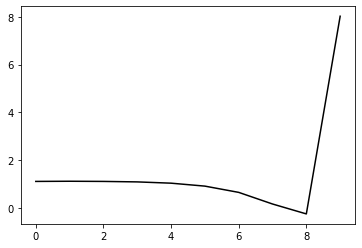

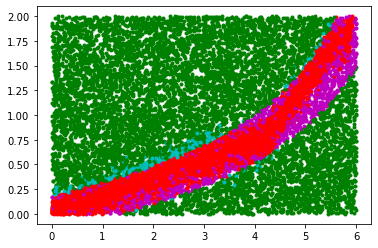

61000 0.22287187412121526
0.2999016620886728 -0.3550914006753849 -0.15058024416068563 -0.1052953170758888
[ 1.11535346  1.12114957  1.1561262   1.14910995  1.07734959  0.92211227
  0.62780693  0.11150439 -0.32533048  7.94335458]


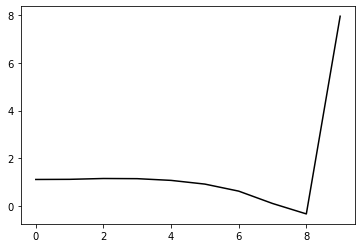

62000 0.13028331620897984
0.2974045336632049 -0.35741921522532294 -0.15645360401252537 -0.10332034993770187
[ 1.08794208  1.07490674  1.11862444  1.11652567  1.05151701  0.8962925
  0.58438639  0.04055292 -0.41846636  7.95547235]


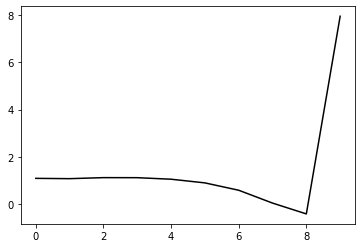

63000 0.24256719482394623
0.29889789298588926 -0.34676138922065525 -0.15293111362577452 -0.10453554204000438
[ 1.13343527  1.13971148  1.16855898  1.1510132   1.09117116  0.94870619
  0.64359449  0.08969499 -0.3785887   7.96917038]


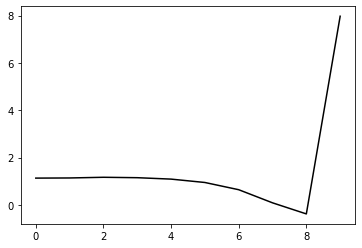

64000 0.20571026982210872
0.2925099734817154 -0.34879139298592027 -0.1572906226347358 -0.1008361425499011
[ 1.07342089  1.02511138  1.01125241  0.9798224   0.90375389  0.75186091
  0.44887231 -0.10344685 -0.57369701  7.9356605 ]


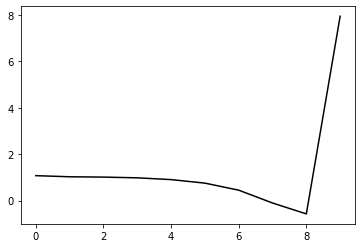

65000 0.19424779484405383
0.29094081142369954 -0.3404562256416966 -0.15379504202544161 -0.10782801564449127
[ 1.08827513  1.13324037  1.15084741  1.13461488  1.07309806  0.92678102
  0.62084236  0.0619388  -0.42123795  7.98226249]


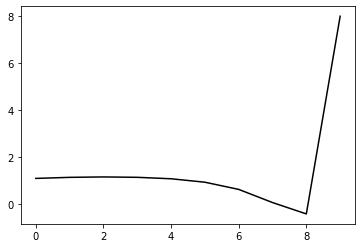

66000 0.24228404879295026
0.28793217682330413 -0.33622833519261475 -0.15520596502889486 -0.10821512123918449
[ 1.09252398  1.09118575  1.12523023  1.12581983  1.09510318  0.98726371
  0.71552582  0.17911248 -0.29375379  7.97733906]


67000 0.17494660437221193
0.2850898692373737 -0.33538319656991333 -0.15772123870543256 -0.10642573355559627
[ 1.0900746   1.03424153  1.07003949  1.09362055  1.05929911  0.93583822
  0.66114572  0.12784215 -0.35053723  7.94499717]


68000 0.18387686433185813
0.28529421782846953 -0.33024484743366506 -0.15821039711898996 -0.10718355917490385
[ 1.10313744  1.1006444   1.1420502   1.14457958  1.09970601  0.97694561
  0.70469536  0.17553921 -0.30711632  8.04114294]


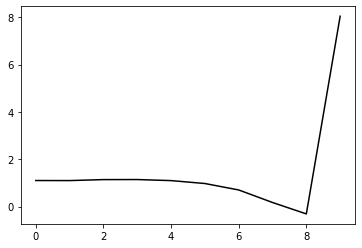

69000 0.1851088458468055
0.28759893758152266 -0.3242718424687175 -0.15890817350237732 -0.10681805075807622
[ 1.09672665  1.12867037  1.16857468  1.15431968  1.09521696  0.96870386
  0.69842771  0.1725508  -0.31192847  7.98597863]


70000 0.18386118291438291
0.28438625388399474 -0.31753195836493864 -0.1575606996746406 -0.10409854754745453
[ 1.10745218  1.15037595  1.14606517  1.11992981  1.06195166  0.93614001
  0.66414202  0.13796563 -0.35094662  7.99537634]


71000 0.23749993055066665
0.280088740977176 -0.31803236424440284 -0.15942456699778954 -0.10620741471877594
[ 1.12185099  1.11517699  1.11930235  1.09441573  1.0421837   0.92473415
  0.66661058  0.16185383 -0.3036354   8.00007574]


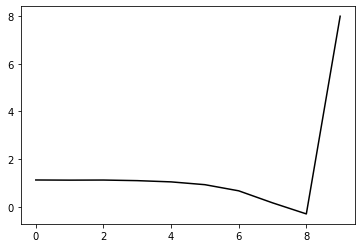

72000 0.21595541471651483
0.2781535930546872 -0.3160680108957367 -0.1605276202169809 -0.10644882387127186
[ 1.0647143   1.06042053  1.08524192  1.09113577  1.04757435  0.92292784
  0.66003248  0.16368876 -0.2860351   7.9651251 ]


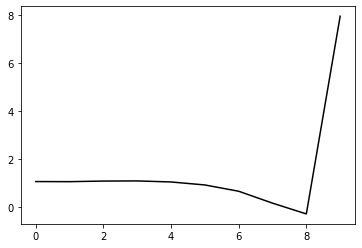

73000 0.2305559942133596
0.2767299162651624 -0.3110129844703996 -0.16013925415302294 -0.10719624221876158
[ 1.09080971  1.09465669  1.08688991  1.06797727  1.02258216  0.90441296
  0.6408321   0.14222088 -0.30321106  8.0082991 ]


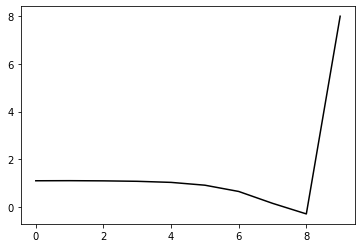

74000 0.19174049238298274
0.27517552051350697 -0.30622532991141227 -0.16020077771233882 -0.10628123452522391
[ 1.11261517  1.10511647  1.13852326  1.12257096  1.05286888  0.91869983
  0.65177211  0.15032282 -0.29709567  8.04226305]


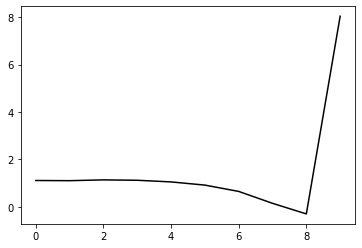

75000 0.25786882481920914
0.2729750814990571 -0.30169866793767935 -0.15979292065289244 -0.10419440366539344
[ 1.11573674  1.07609324  1.06821339  1.04940097  1.00628985  0.89058061
  0.63379902  0.14791258 -0.27626605  8.01554499]


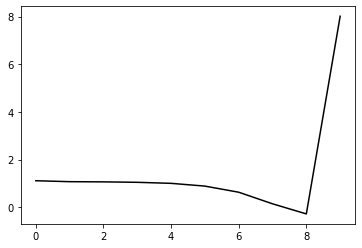

76000 0.20453941635314762
0.2683762768478475 -0.29764250517486235 -0.15905039557684852 -0.10877240558905123
[ 1.11033387  1.14934426  1.14453126  1.09276151  1.00526791  0.85917414
  0.58936642  0.09687507 -0.32787121  7.98596312]


77000 0.21186463184688353
0.2652453173581442 -0.30087803739144076 -0.16475170855137866 -0.10657045410134429
[ 1.09765578  1.07857511  1.08706134  1.07303592  1.01585269  0.88091356
  0.60831512  0.12056957 -0.28922031  8.000012  ]


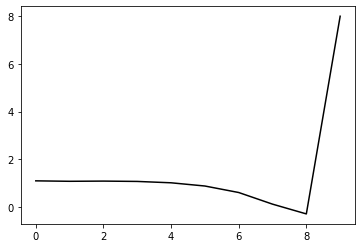

78000 0.19478687986649074
0.2655576762533079 -0.2955821899434485 -0.163329730463947 -0.10559112959602761
[ 1.08395449  1.04324068  1.04151653  1.01916992  0.94779284  0.80372228
  0.51798104  0.01131051 -0.40531122  7.96821336]


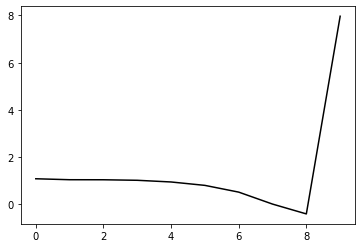

79000 0.22850993813267972
0.26187764909601585 -0.28950200659704745 -0.16154059789991543 -0.10854373300110226
[ 1.10067555  1.110382    1.11550738  1.11005451  1.06474714  0.94068519
  0.6674876   0.16299533 -0.25286195  8.00742283]


80000 0.2572629224991434
0.2644664016194997 -0.28738429397038845 -0.16400142837978482 -0.10739025880572228
[ 1.11231337  1.09803647  1.10543155  1.07276891  1.0104438   0.88175337
  0.61321671  0.11262721 -0.2988205   7.99055066]


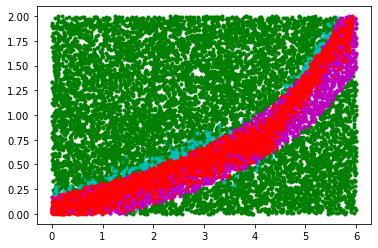

81000 0.20960774652089184
0.2654287082397267 -0.2836298592905127 -0.16413430678879293 -0.10729662017882766
[ 1.09987706  1.16975206  1.177858    1.12898425  1.04257601  0.89330058
  0.61219295  0.1077067  -0.30333709  7.95992317]


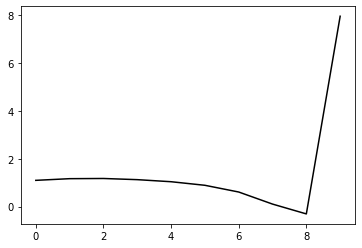

82000 0.24679918186723723
0.2648725797724004 -0.2860860732335568 -0.16877373446845773 -0.10459706637553243
[ 1.08450567  1.06915665  1.08792567  1.07609934  1.0114319   0.86565409
  0.57823805  0.06982951 -0.33961049  7.98447615]


83000 0.21637657045176129
0.2633606783007473 -0.28145817367893083 -0.16813970814020096 -0.10314216123655896
[ 1.07936931  1.06858843  1.06469908  1.03448422  0.97650572  0.84028714
  0.55474138  0.04233366 -0.36670333  7.98252495]


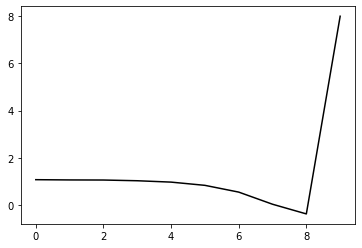

84000 0.2003143512968314
0.2599071178546738 -0.27845895800396 -0.1675877617175573 -0.1072032591919764
[ 1.05402436  1.02599561  1.04797795  1.03465294  0.97710773  0.84317582
  0.56750978  0.06335208 -0.33805485  8.00037041]


85000 0.17750921043902632
0.25684719976900033 -0.2785085007074768 -0.16860416550304358 -0.11075369042472777
[ 1.073343    1.08498023  1.080146    1.04553793  0.97798945  0.84963451
  0.5923509   0.11373477 -0.25827251  7.99840597]


86000 0.12831015455636663
0.25596584639284564 -0.27637830919424433 -0.16946440491625875 -0.10728276614143892
[ 1.0499727   1.035799    1.02632671  0.98504726  0.90983264  0.76581217
  0.49548151  0.01607066 -0.35100099  7.99936069]


87000 0.17661845296789805
0.2541615596596316 -0.2714972622116743 -0.16800461284893056 -0.11054445964260702
[ 1.10280641  1.0799749   1.10537172  1.09100566  1.02456265  0.88173824
  0.6060913   0.12388271 -0.24068656  8.03156716]


88000 0.2549104172267451
0.25120611695148365 -0.2706622053028877 -0.16881252705585068 -0.11173163072526644
[ 1.08143471  1.0897529   1.07873686  1.05309003  0.98986984  0.85617353
  0.5859971   0.10604173 -0.25054426  8.03070391]


89000 0.15915017706708745
0.24807447615141068 -0.26736107308976065 -0.16840956512335106 -0.1109115050735709
[ 1.08427644  1.07369337  1.05021923  1.01093157  0.94982238  0.83270233
  0.58523938  0.1229168  -0.21742881  8.00913411]


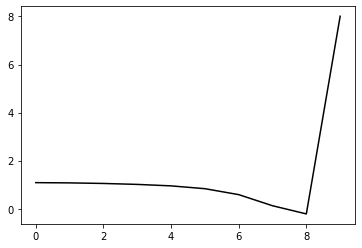

90000 0.28522793580885586
0.244929379331907 -0.2669278900522299 -0.17080642335093724 -0.11127035799024822
[ 1.06241668  1.06799084  1.04481373  1.01237577  0.96004199  0.84314253
  0.60117827  0.15170693 -0.17828914  8.01834308]


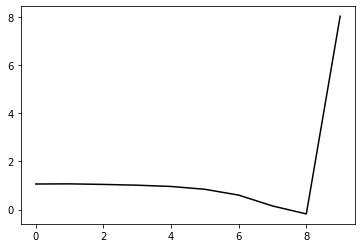

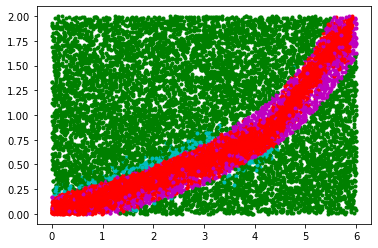

91000 0.15200833726834456
0.2452921531284189 -0.2638514967067327 -0.17038880858604816 -0.11219697892722233
[ 1.06039468  1.03087531  1.02641708  0.98977206  0.92334594  0.79533893
  0.54554321  0.09852701 -0.22116949  8.03682091]


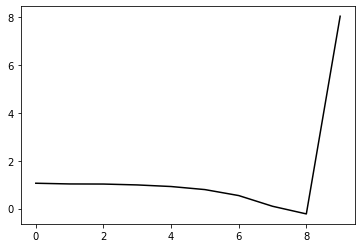

92000 0.18746046816610412
0.24388048666800377 -0.2622218489093426 -0.17269749386533806 -0.11004581885766727
[ 1.09176874  1.03830858  1.02717387  1.00258229  0.94550332  0.82360119
  0.58261179  0.14974759 -0.15215905  8.01922141]


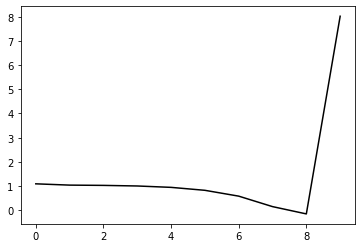

93000 0.2647444222908546
0.24744672762513129 -0.25441160401163504 -0.1697914369484783 -0.11098647776888577
[ 1.08514989  1.11329468  1.10972109  1.06114522  0.9800123   0.83400417
  0.56814896  0.12018734 -0.18259314  8.01346205]


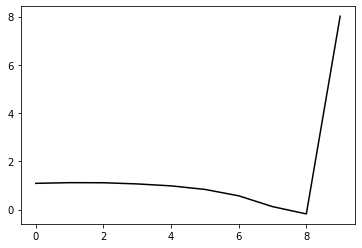

94000 0.23906536396662031
0.2468742361889131 -0.2585578325428041 -0.17435002332552582 -0.11219447054924511
[ 1.07519188  1.10479987  1.0907829   1.03931075  0.95033359  0.79205328
  0.51586147  0.06435129 -0.22593186  8.01936797]


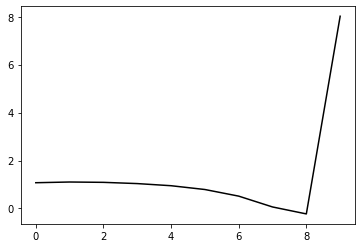

95000 0.19827213496623813
0.24494171906673098 -0.25369362385303834 -0.17297148513951704 -0.10900304726816593
[ 1.07693408  1.01625559  1.00545853  0.9801895   0.90649317  0.74794338
  0.45497111 -0.01849978 -0.32068893  7.99494375]


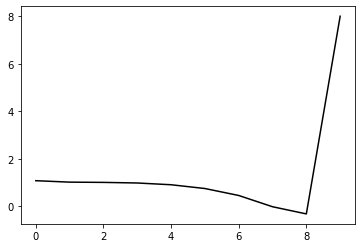

96000 0.1730379553526704
0.2483835601900881 -0.24937520982552483 -0.17474405683782998 -0.10838365380195146
[ 1.09363753  1.07540741  1.09819382  1.08091887  1.01344021  0.87552833
  0.60242573  0.12764263 -0.18077991  8.05357025]


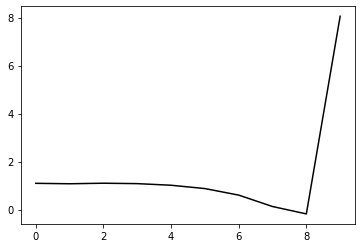

97000 0.2024754479717135
0.24215629393271776 -0.2478973279800931 -0.17402279012063246 -0.11094125342199876
[ 1.07485809  1.09896257  1.09252544  1.06236455  0.98890654  0.84962734
  0.57814014  0.10144288 -0.21137344  8.01221646]


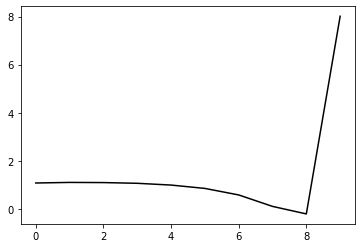

98000 0.2436050685992556
0.24248669280174862 -0.2466560172671879 -0.17585749993324157 -0.10791480093931727
[ 1.05962174  1.00716178  1.01825045  1.00235929  0.92663478  0.77639705
  0.50063039  0.02380561 -0.29261389  8.00819837]


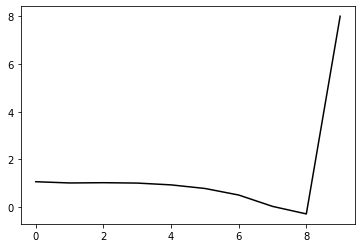

99000 0.2220566063244072
0.2379260704261159 -0.24654331323535186 -0.17527612129402637 -0.1146710433868978
[ 1.07158709  1.05575778  1.04333712  1.01153687  0.95113245  0.81845155
  0.55630025  0.09756849 -0.19689539  8.01211731]


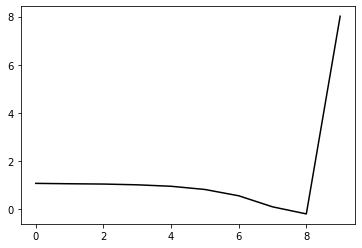

In [17]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
        if np.isnan(loss)==True: break
    for i in range (90):
        optimizer.apply_gradients(zip(gradients, [h]))
        if any(np.isnan(h.numpy()))==True: break
    for i in range (10):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()

0 0.3558736811507107
0.2436923953759385 -0.2550416681712157 -0.18632774202464292 -0.11780591017575619
[ 0.99642405  1.01358612  0.99077311  0.93670606  0.83565245  0.6714712
  0.39145132 -0.07857534 -0.3828642   8.00609004]


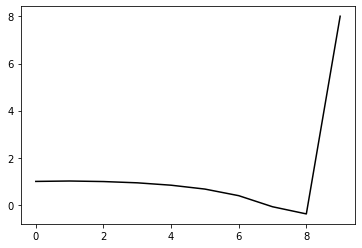

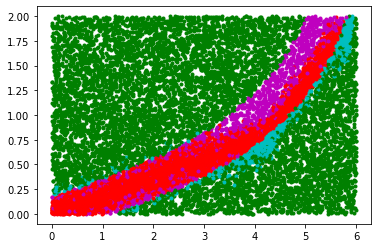

1000 0.19844460016523427
0.2572878728649767 -0.24187143658824495 -0.17893656061059673 -0.1268383301781566
[ 1.02146572  1.03374397  1.00599601  0.93415367  0.80478973  0.59379123
  0.26146366 -0.24742252 -0.57519216  7.95840919]


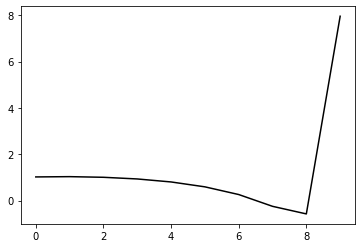

2000 0.2243116606430656
0.25433659866267694 -0.23971955215964724 -0.18052699647570963 -0.12362880384869389
[ 1.03469829  0.97704602  0.95575379  0.91748105  0.82329344  0.62735724
  0.2792967  -0.25743086 -0.60279895  7.97045078]


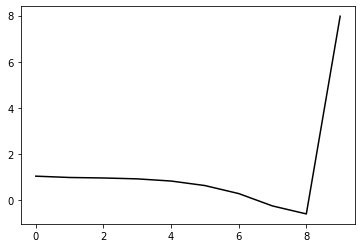

3000 0.14594806186551024
0.25055835497356094 -0.23892653553393914 -0.18209112265091482 -0.12193239225837489
[ 1.04894801  0.94510905  0.9370773   0.90740125  0.81680139  0.63165279
  0.2865228  -0.27261988 -0.64340698  7.92281549]


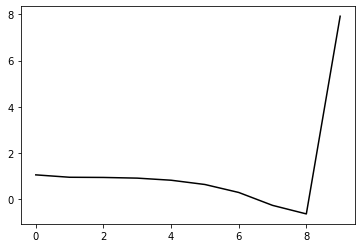

4000 0.3572930015808091
0.2559061707350127 -0.22609781563325185 -0.1758480309892308 -0.12461171740207175
[ 1.0760908   1.05574697  1.08027527  1.05923417  0.96438571  0.77272891
  0.42066297 -0.1635354  -0.57178926  7.93197323]


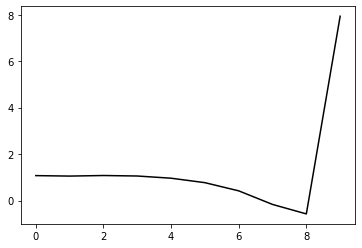

5000 0.284675666096673
0.2556296355380106 -0.23191864574508195 -0.18227926874787265 -0.12068154184239548
[ 1.04123564  0.99580326  0.99068836  0.95347971  0.85884506  0.66849045
  0.31641833 -0.27447141 -0.69806097  7.89394995]


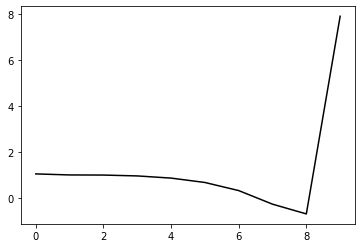

6000 0.2122558329717716
0.2537669542777408 -0.23129097383997052 -0.18479656908550884 -0.11784683532088155
[ 1.05365246  1.02568895  1.01930611  0.97616823  0.89066174  0.73600829
  0.42524181 -0.13787901 -0.55423981  7.98188804]


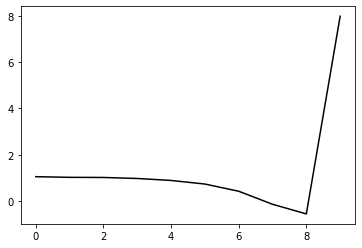

7000 0.20598682550542172
0.2523776546200486 -0.22067006153602825 -0.17988706841946217 -0.1206411167074685
[ 1.09671132  1.12473644  1.12165349  1.0796148   0.98975944  0.82123546
  0.50244334 -0.06555046 -0.50847898  7.96107295]


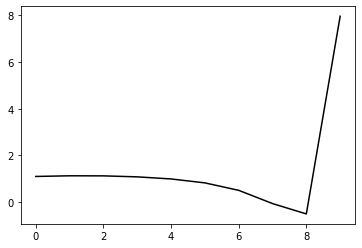

8000 0.12701215800920346
0.25374937580623486 -0.22262920165045116 -0.18362913287037078 -0.11915172137575643
[ 1.09254399  1.09881815  1.0956891   1.03602127  0.93988098  0.77086449
  0.45296327 -0.10689524 -0.54673519  7.94413348]


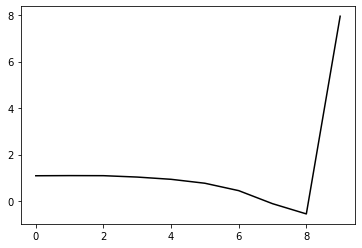

9000 0.1988290901409755
0.24888923920337067 -0.21940194542386363 -0.1829485262584943 -0.11798354303194826
[ 1.10170047  1.08016618  1.06311469  1.01303974  0.93170234  0.77477334
  0.46747539 -0.08247347 -0.52221811  7.94733925]


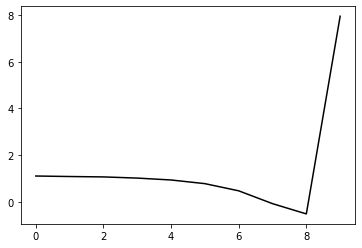

10000 0.217786671645825
0.2459333763439074 -0.22152467624066738 -0.18700434408981703 -0.11650378296426321
[ 1.08759932  1.10770435  1.0809532   1.04052512  0.95846422  0.79494249
  0.48609071 -0.06162797 -0.50691008  7.97558566]


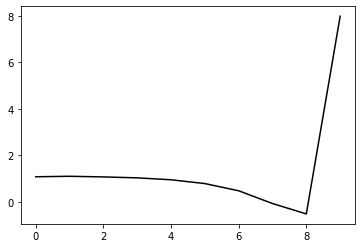

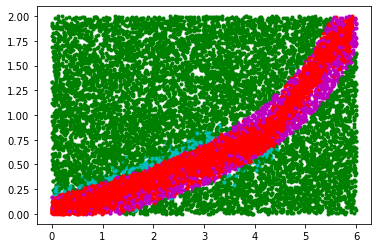

11000 0.24343112536227
0.25142383210218516 -0.21426513047663273 -0.18418098448891576 -0.11518713145052793
[ 1.12896105  1.10240736  1.11534256  1.0709966   0.975439    0.79491909
  0.46395718 -0.10045984 -0.55832774  7.9469285 ]


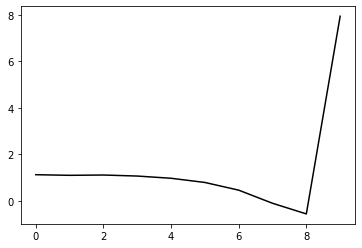

12000 0.21179661542169895
0.2487505481418216 -0.21521784526824442 -0.1861536920734427 -0.11703831177092752
[ 1.10396617  1.13846736  1.11804018  1.07154307  0.97895191  0.79751247
  0.4636256  -0.10181188 -0.55447739  7.93192265]


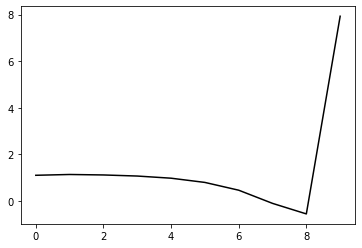

13000 0.19020011200565085
0.2479185689473059 -0.2135504750581007 -0.18687841900733024 -0.11894141650548888
[ 1.10088049  1.11139962  1.09505515  1.03986532  0.94884764  0.79098316
  0.48690721 -0.0555102  -0.48605103  7.96386283]


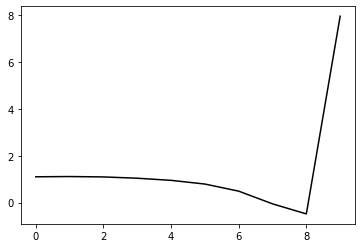

14000 0.2248591880544432
0.25004331610778857 -0.21031489558271313 -0.18674037606845684 -0.11897029256636103
[ 1.10204121  1.08682809  1.07547004  1.01770153  0.92357259  0.75427128
  0.44041772 -0.10504583 -0.53916339  7.95470763]


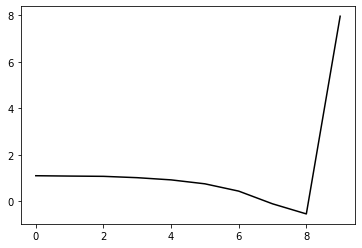

15000 0.2972550297595726
0.25166421081630896 -0.20955574689276665 -0.18822958448414165 -0.11844675981949408
[ 1.09798769  1.11387351  1.11410015  1.06636425  0.97251856  0.78550822
  0.44039404 -0.13435806 -0.59325573  7.93969896]


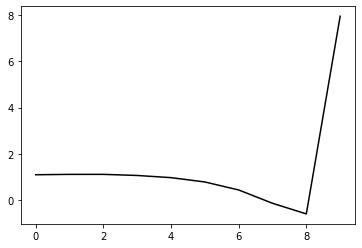

16000 0.15499383906236913
0.24882257582600611 -0.20919570028191523 -0.1890701574393504 -0.11479893726997412
[ 1.05926833  1.07159638  1.06040691  1.01479646  0.93417913  0.77233995
  0.44652263 -0.12642559 -0.58833217  7.92807698]


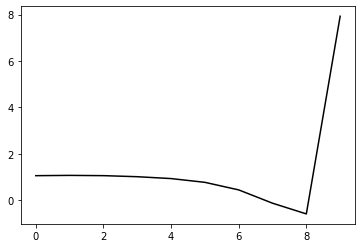

17000 0.25125740647168765
0.24095151675020549 -0.21036881426900314 -0.18943229983938809 -0.11535007815633413
[ 1.09894322  1.05630225  1.03332451  0.99930626  0.92825557  0.7766828
  0.46947662 -0.08867088 -0.54429856  7.95156175]


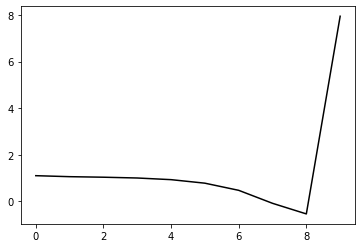

18000 0.1901281483685351
0.2432337418636715 -0.2065051028407133 -0.18851573002730274 -0.11822610604223859
[ 1.09596145  1.07050121  1.08885119  1.0592357   0.97079922  0.80196438
  0.48939615 -0.06227547 -0.51186966  7.95754395]


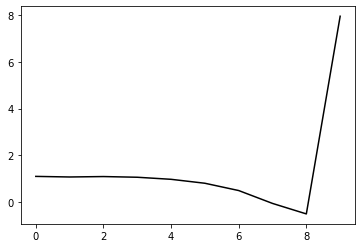

19000 0.22604857937188183
0.23687714099943583 -0.20889883856395472 -0.1907429884319471 -0.11768606899041477
[ 1.08960962  1.10440674  1.09364601  1.04004448  0.94097328  0.77243907
  0.46120936 -0.08541234 -0.53018255  7.95392225]


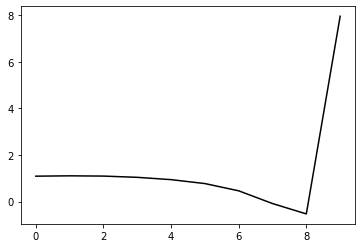

20000 0.203498894624265
0.2395392654137406 -0.204872666081487 -0.18904824652822777 -0.11874241457575777
[ 1.0937837   1.10107188  1.0950965   1.04263883  0.94337476  0.75989928
  0.4255847  -0.13651356 -0.58566084  7.95757794]


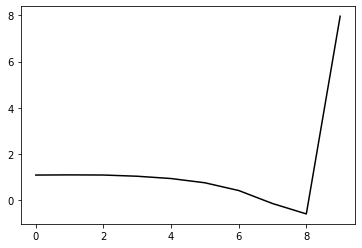

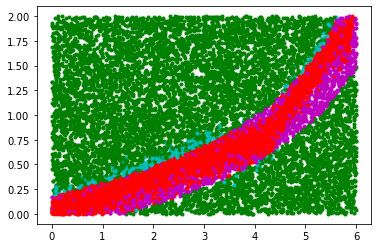

21000 0.15410438284451958
0.2358292620258672 -0.207522262190132 -0.19225032249144317 -0.11173571692948975
[ 1.05885552  0.97515122  0.95514182  0.91922201  0.84060739  0.67425624
  0.34520399 -0.22191652 -0.67385935  7.95894297]


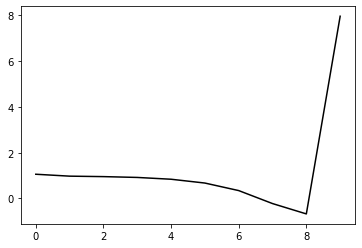

22000 0.1977913464761039
0.23317814347379665 -0.20677164502352993 -0.1918357915435028 -0.11809626451399513
[ 1.06264053  1.02787721  1.018115    0.99307773  0.93330426  0.78919658
  0.48689879 -0.05984949 -0.49402493  7.93591758]


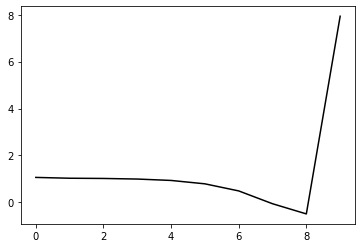

23000 0.2420635700449648
0.2312809220222435 -0.2040872163326306 -0.19114055668790697 -0.11596199259888593
[ 1.0805477   1.05502022  1.03765263  1.0057134   0.92200612  0.76069753
  0.44979691 -0.10624106 -0.55768069  7.94359063]


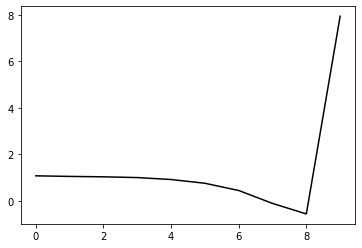

24000 0.20895946833429008
0.23530509157307078 -0.20565807097587172 -0.19317242239175245 -0.11501926236503021
[ 1.0607496   1.01957246  1.03993841  1.0160067   0.92357292  0.73791122
  0.40021075 -0.17418462 -0.64123154  7.9566918 ]


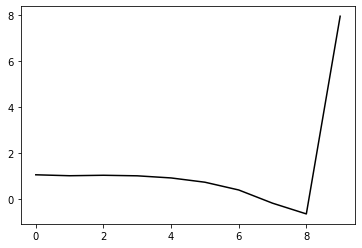

25000 0.2011266401774404
0.23105631954357977 -0.20173317199415933 -0.19021944270634258 -0.11973038085690738
[ 1.07810411  1.08936639  1.0928945   1.03086631  0.92601998  0.75230715
  0.42481449 -0.14812362 -0.61585093  7.95564362]


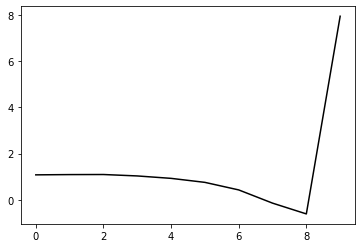

26000 0.20006505080615883
0.23019731535862767 -0.20134825009820842 -0.19141714309915034 -0.11932793380970314
[ 1.08394673  1.0553151   1.06572866  1.04482988  0.97287271  0.80880771
  0.4864824  -0.07720713 -0.53470227  7.940585  ]


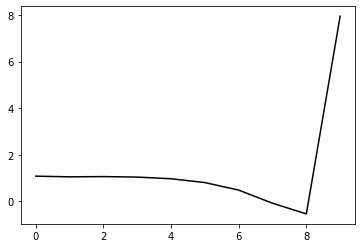

27000 0.22518553286877385
0.23176377897994133 -0.2020592499701989 -0.19322959262907707 -0.11615228462609319
[ 1.06183951  1.04749694  1.0508156   1.02266862  0.94991007  0.79064829
  0.47562688 -0.08452821 -0.54153637  7.94053531]


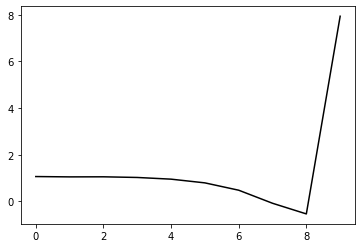

28000 0.1912044461476146
0.22915682977089175 -0.1987741616184676 -0.19216447148561058 -0.11821093924909695
[ 1.09164767  1.06721985  1.07527652  1.03845328  0.9527178   0.79644799
  0.49339238 -0.05826201 -0.51640036  7.96838777]


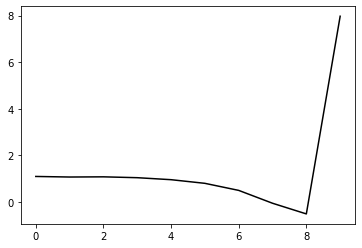

29000 0.1399321654369781
0.22886302285375834 -0.1979432765881471 -0.19267537962357914 -0.11738525981369625
[ 1.07948048  1.14316923  1.11317263  1.04771522  0.94844832  0.78045734
  0.47110558 -0.07652016 -0.53140613  7.93939506]


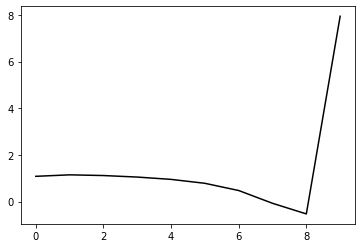

30000 0.18693816748745187
0.2370119924767814 -0.19297614085049986 -0.19162159779588542 -0.11805455686293984
[ 1.09709811  1.08256838  1.10502631  1.08717725  0.99577922  0.81096608
  0.4812558  -0.0729564  -0.52355847  7.94782131]


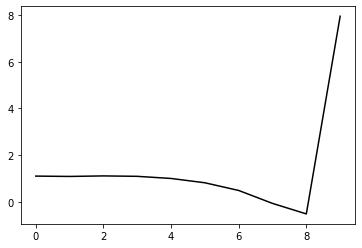

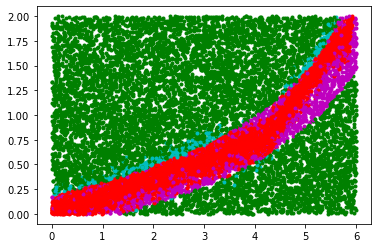

31000 0.2802720649824503
0.2351247534569415 -0.1984374458926257 -0.1962553073901728 -0.11692701946061651
[ 1.10421119  1.1387397   1.12122265  1.07264264  0.97785339  0.79591627
  0.463867   -0.09495235 -0.54025197  7.94900846]


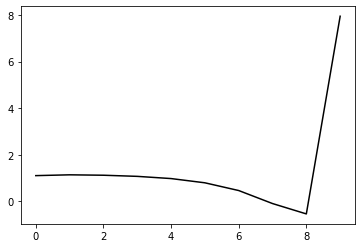

32000 0.18127740614109103
0.24019209389480908 -0.1960885101187258 -0.19669758969482637 -0.11553719458266153
[ 1.08204436  1.02353204  1.03645339  1.02913914  0.94801712  0.7586481
  0.40243531 -0.18887405 -0.66258407  7.93269966]


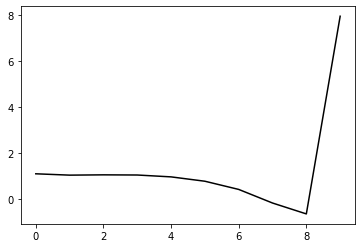

33000 0.23351944829420757
0.23347013474823639 -0.19187795883977182 -0.19430676834241722 -0.11919807690439263
[ 1.10322681  1.07061391  1.06764916  1.04719062  0.99108752  0.84292275
  0.51969513 -0.06210763 -0.53529483  8.03777157]


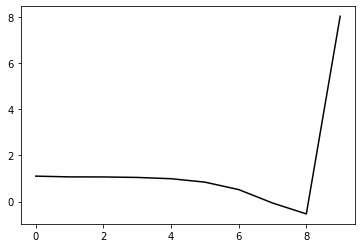

34000 0.16363664720305343
0.23023270811446866 -0.190724361318522 -0.19319679556947372 -0.11949307966341736
[ 1.07727013  1.06202818  1.07074792  1.05515299  0.98191424  0.81347813
  0.48477197 -0.09990247 -0.58279546  7.93526563]


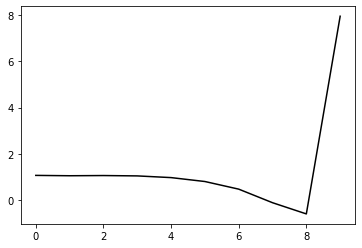

35000 0.17785372199882382
0.2298247227874074 -0.19229069808922408 -0.1944742309114772 -0.11985066713036258
[ 1.08218672  1.11906598  1.10071788  1.04209892  0.94366148  0.77664062
  0.46073226 -0.10968442 -0.58504065  7.93672149]


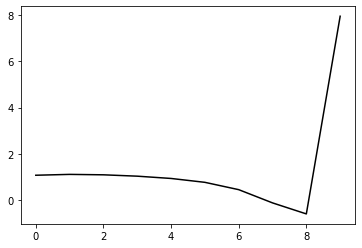

36000 0.3187660124912154
0.23500636862266394 -0.1912411840852504 -0.19535362913225846 -0.11772024586663445
[ 1.09242984  1.13067139  1.1297448   1.10156799  1.01199965  0.81530338
  0.45561472 -0.14779361 -0.65457764  7.92717314]


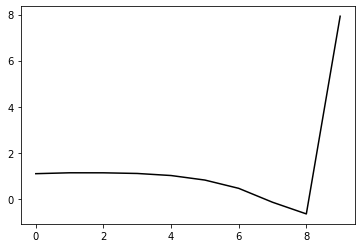

37000 0.22579451943129647
0.2334063241492719 -0.18950856698847277 -0.19392767549847262 -0.11995658458248237
[ 1.10427906  1.07285617  1.06387521  1.02663098  0.95692338  0.80154975
  0.47650991 -0.1060588  -0.59068841  7.92702539]


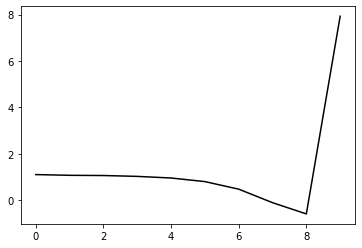

38000 0.25649789316968874
0.235444269214158 -0.1870213635419375 -0.1933047221976689 -0.12051680462589959
[ 1.09168457  1.12358774  1.12554529  1.09180735  1.00342291  0.81870479
  0.47804893 -0.11379913 -0.61106042  7.93193143]


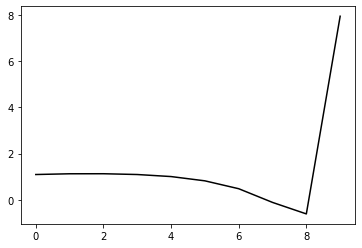

39000 0.2302896120668943
0.2299468963580803 -0.19341266821931777 -0.19722624651560983 -0.12097697956726432
[ 1.07295392  1.07416165  1.06698688  1.03810479  0.9521293   0.77878031
  0.44946084 -0.1301053  -0.6155634   7.90581022]


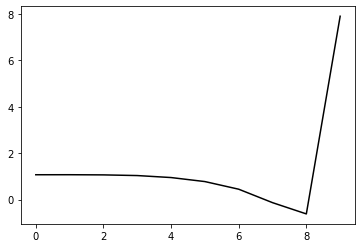

40000 0.17646599860938722
0.23259000986928705 -0.1892329187522935 -0.19635345502270524 -0.12101148089907218
[ 1.07845841  1.07437399  1.06904408  1.02457178  0.93448117  0.76101652
  0.43309855 -0.14199918 -0.62076759  7.9313715 ]


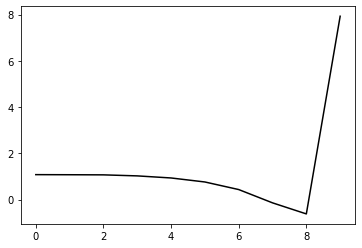

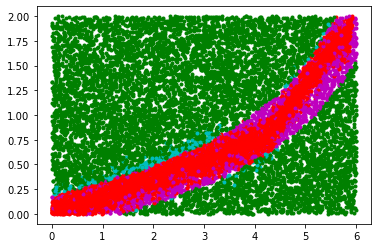

41000 0.21738696763052348
0.2335854694808634 -0.18695641074903258 -0.19562063026040688 -0.12257198329144199
[ 1.09594127  1.13575262  1.14008375  1.10958651  1.01958485  0.83797679
  0.4949291  -0.09740465 -0.59475847  7.92237272]


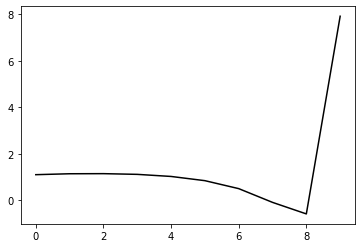

42000 0.24113003316944281
0.23644322686771252 -0.1844686197388168 -0.19660672438003432 -0.11896896237369933
[ 1.09960924  1.10725583  1.1073794   1.07089691  0.98548698  0.80790675
  0.46522281 -0.1328305  -0.63987354  7.94275941]


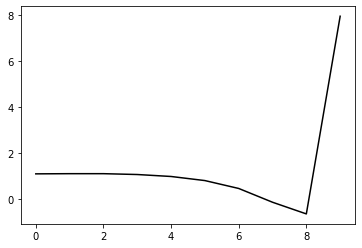

43000 0.23292335604162032
0.23160731388562564 -0.18478666576677286 -0.196501444100994 -0.12187765721497684
[ 1.09768034  1.04482956  1.03450001  0.99789904  0.9203647   0.76205424
  0.44848004 -0.11988787 -0.59901718  7.92788065]


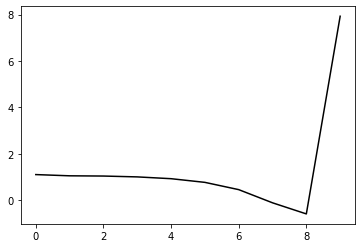

44000 0.2289432803072189
0.23366503195936783 -0.18342776375596467 -0.19540033045788832 -0.12331648690388557
[ 1.08294851  1.07035826  1.05327773  0.9892439   0.88339231  0.70233442
  0.38122976 -0.17765859 -0.64301796  7.91664469]


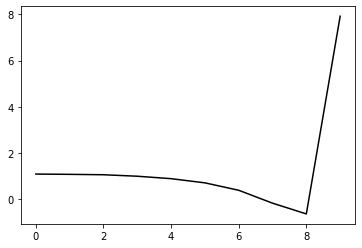

45000 0.1656346869875967
0.23100271119534624 -0.18281796268504621 -0.19605940311530665 -0.12299493737036961
[ 1.06023571  1.09500882  1.06737815  1.02403366  0.93379263  0.7611958
  0.43884534 -0.11989083 -0.5833084   7.93631328]


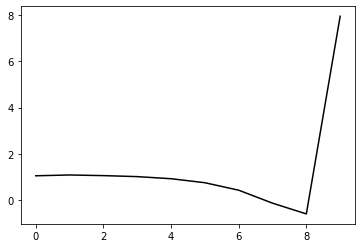

46000 0.2308127603413151
0.2314893763933404 -0.18479439780859616 -0.19870415256781246 -0.12263302126381492
[ 1.0680669   1.073478    1.05674951  1.00211106  0.90400541  0.72781471
  0.40792195 -0.14461926 -0.59618973  7.93075453]


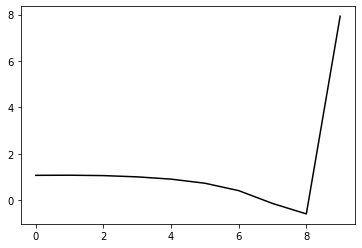

47000 0.13620349800601686
0.23221787623686413 -0.18468308516991158 -0.2001028068345972 -0.1201956992004561
[ 1.06339294  1.03119292  1.02335396  0.96546653  0.85845359  0.68311185
  0.37018376 -0.16893658 -0.59961763  7.94441162]


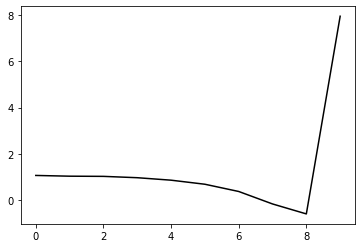

48000 0.22630391811617545
0.2308768521675561 -0.17786298156530128 -0.19666631821568686 -0.12351232934612258
[ 1.09101741  1.12826345  1.11035954  1.06477015  0.97945932  0.80817192
  0.48688047 -0.0602824  -0.4973738   7.93240642]


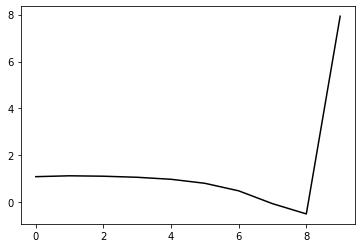

49000 0.1655307203668992
0.23501444061539425 -0.18201341736620782 -0.20068218741124785 -0.1196982231936916
[ 1.05806035  0.96305311  0.95773566  0.92519051  0.82086251  0.62895492
  0.29641386 -0.25844174 -0.69386474  7.93290057]


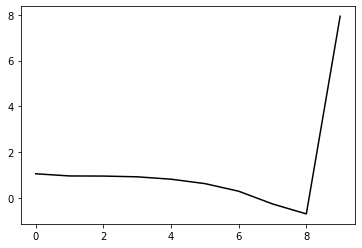

50000 0.19456050785809864
0.23764780142447856 -0.17948025896354347 -0.20011026746603075 -0.12157850494344927
[ 1.10988413  1.05951281  1.0570068   1.01853273  0.9178972   0.73036287
  0.3978168  -0.15825918 -0.58898066  7.94154025]


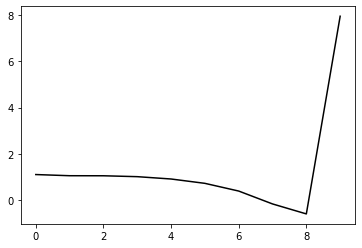

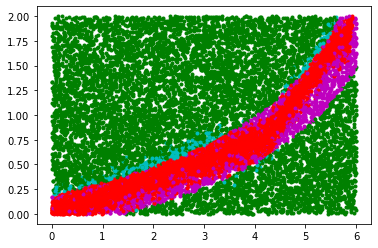

51000 0.14806709862488546
0.23745963664331804 -0.1794871800266093 -0.201073855429712 -0.12154872039478617
[ 1.10772037  1.06483331  1.09413148  1.08430693  1.00145645  0.8156167
  0.46834522 -0.109018   -0.55662232  7.9905159 ]


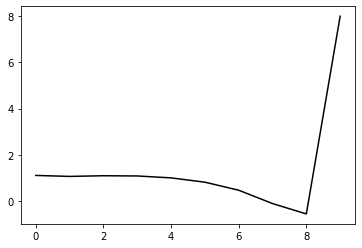

52000 0.17658824093904904
0.23436301268452975 -0.17855852385097648 -0.20000232313995964 -0.12125682121058173
[ 1.1161671   1.10343714  1.09665752  1.05631918  0.9664117   0.77846367
  0.41855273 -0.18816335 -0.66554736  7.89669846]


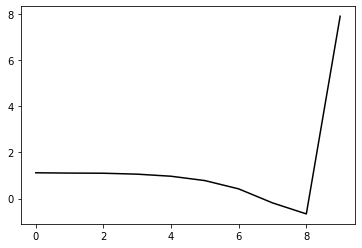

53000 0.16354884429024924
0.2298927315260284 -0.18282076014092438 -0.20173364893838117 -0.12455964319308141
[ 1.08188891  1.09845816  1.07548593  1.03905393  0.94755988  0.75598297
  0.39511451 -0.21948989 -0.70819012  7.91863872]


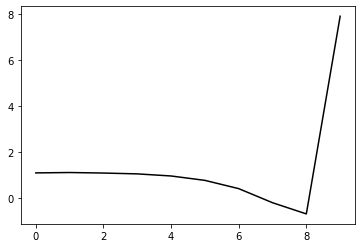

54000 0.19462322921649097
0.23177843703599196 -0.18109628059343202 -0.2012699860377805 -0.12588567442851245
[ 1.06743213  1.09517258  1.08345449  1.02712164  0.91643909  0.71998399
  0.35956996 -0.25761215 -0.75313649  7.92189933]


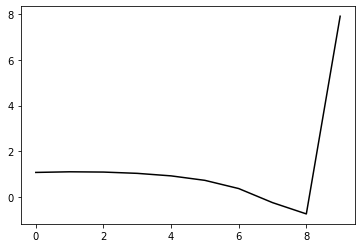

55000 0.1629778015923463
0.23234522389753023 -0.18134625491797104 -0.20311183657259876 -0.12313526546828296
[ 1.03958621  0.93813743  0.92528096  0.90372533  0.82639472  0.65231079
  0.30847743 -0.2938721  -0.78160953  7.90178916]


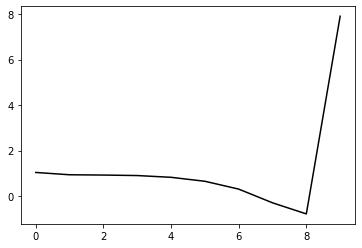

56000 0.25509738214445893
0.2278181500210878 -0.1789323730490632 -0.20077080112108905 -0.12627623361618648
[ 1.04031893  0.9534283   0.94434242  0.90501108  0.80361789  0.62153299
  0.29234087 -0.29067738 -0.76801563  7.92453625]


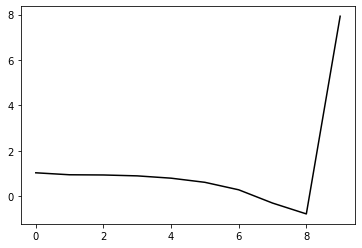

57000 0.22952079852810658
0.2233307475863805 -0.18069581639612314 -0.2018884484592964 -0.12649276629071096
[ 1.04643449  0.98616741  0.97115031  0.91453041  0.80145907  0.61109516
  0.27217219 -0.31361069 -0.79947747  7.91547112]


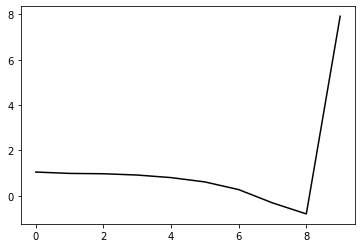

58000 0.1540450350601125
0.2254063022577057 -0.17955391938255227 -0.20443480777824338 -0.12284020942247706
[ 1.04104306  0.94375888  0.92727034  0.90001745  0.82698831  0.6628212
  0.33847943 -0.23382969 -0.71064969  7.9297703 ]


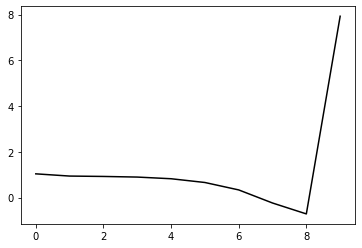

59000 0.2139665845240803
0.22629174916673095 -0.17633061303865535 -0.20231580121545742 -0.1273609583504912
[ 1.0704218   1.08224245  1.06573528  1.00585694  0.89546934  0.71032935
  0.38235237 -0.18849685 -0.66272277  7.93338743]


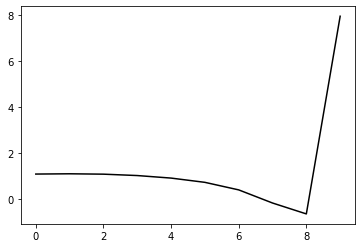

60000 0.24865180199056577
0.2265838501273473 -0.17511310575248903 -0.2018074152907248 -0.12940658262828778
[ 1.05881326  1.03482326  1.02909002  0.97211543  0.87254276  0.69912696
  0.37822576 -0.17823675 -0.6320246   7.95777669]


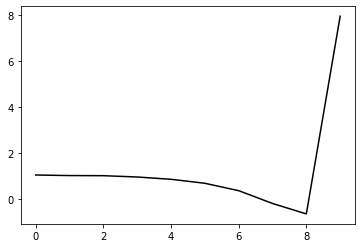

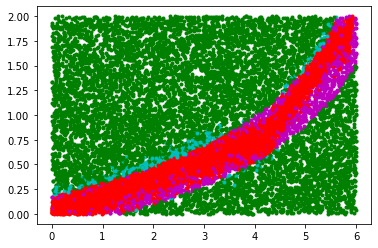

61000 0.20738157451881647
0.2264149529827144 -0.17428937991464916 -0.20210721589992192 -0.12779717377470154
[ 1.06002547  1.05843768  1.03318159  0.96585268  0.85839839  0.67722572
  0.35122393 -0.20755022 -0.66188454  7.91050483]


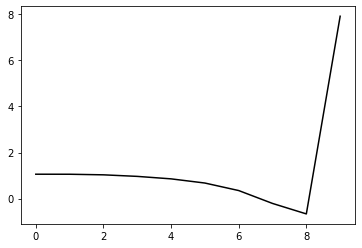

62000 0.24119004593641008
0.22714267906303365 -0.1696945482133556 -0.1994919918895415 -0.13063711883875814
[ 1.08760518  1.03587972  1.05643422  1.01979599  0.92078262  0.74321842
  0.4215105  -0.13023549 -0.57265412  7.94183222]


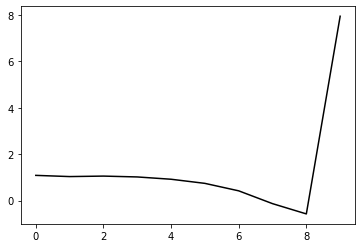

63000 0.20804754249098292
0.22389591249776616 -0.1736016154950372 -0.2021417177852849 -0.13088359068719155
[ 1.03365071  1.05256706  1.01098298  0.93239731  0.81210754  0.62261561
  0.29594529 -0.25736271 -0.69737379  7.94539201]


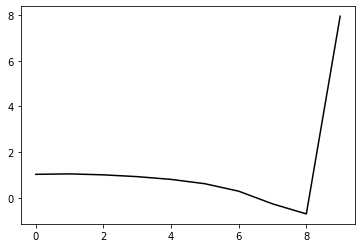

64000 0.20850385865259746
0.2257544623204336 -0.17108516118397293 -0.20140296567802393 -0.12980419787760494
[ 1.0422487   1.05240276  1.04457033  0.956947    0.82514313  0.62463018
  0.28362452 -0.27833801 -0.71847171  7.91841216]


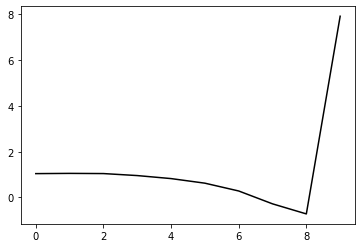

65000 0.19251661396038666
0.22340338004074395 -0.1723641934605753 -0.2032098196407043 -0.13041133608241168
[ 1.05330614  1.03721064  1.02410389  0.96957537  0.86268511  0.66866563
  0.32391383 -0.24322418 -0.68230451  7.90966416]


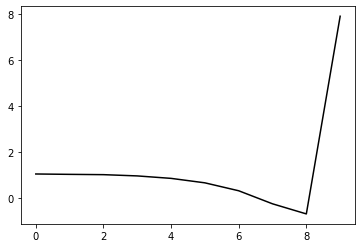

66000 0.24272160637455978
0.22108937168909604 -0.17159995100725645 -0.2026381675752418 -0.1302927642980834
[ 1.04801931  1.04619873  1.00735158  0.93254338  0.81820088  0.62372408
  0.27786111 -0.2959669  -0.73672137  7.92657529]


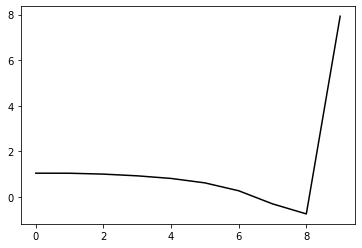

67000 0.2844054920139996
0.22208613174823344 -0.16566527095458913 -0.19912473625276972 -0.13042214658291015
[ 1.06216317  1.09913477  1.08188247  1.02570961  0.91469365  0.71598481
  0.36569259 -0.21613364 -0.66449145  7.90222119]


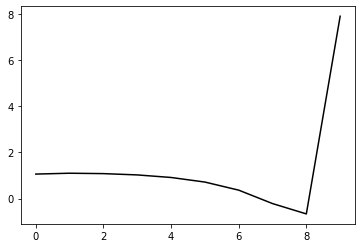

68000 0.18135518664536962
0.22357327083578507 -0.17032297223780365 -0.20373612492541826 -0.1280233231044494
[ 1.03898159  1.04569419  1.05310459  1.01401752  0.92407094  0.74225925
  0.40329813 -0.16812611 -0.60185853  7.9219632 ]


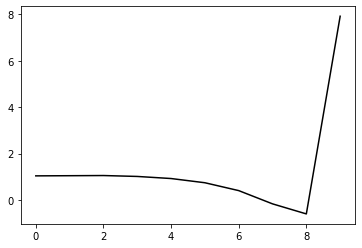

69000 0.18186178375027262
0.22049444588873604 -0.16982205917131135 -0.20327105757016395 -0.1296068269633473
[ 1.04736405  1.09708156  1.07415532  0.99865159  0.88610171  0.70025269
  0.35999192 -0.22041395 -0.66694665  7.94027554]


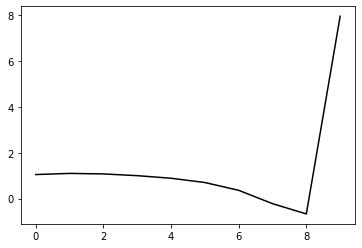

70000 0.18645093100421362
0.22689118133424035 -0.16977561957975193 -0.2051669510289444 -0.12862134337011266
[ 1.07824122  1.05216493  1.05362857  1.00907852  0.90289073  0.70640001
  0.35938555 -0.22033881 -0.66303184  7.94622667]


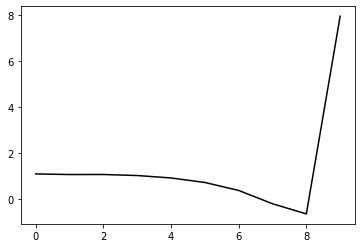

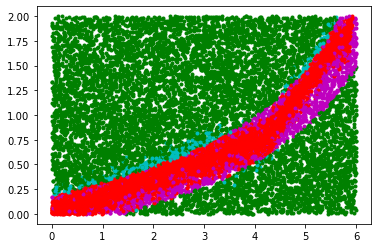

71000 0.23714422777509492
0.2246407537523283 -0.16761494949704472 -0.20434929303265606 -0.12819816615613797
[ 1.0702316   1.04377959  1.06003961  1.02426638  0.92502628  0.73297597
  0.38075944 -0.2124906  -0.67353021  7.9064804 ]


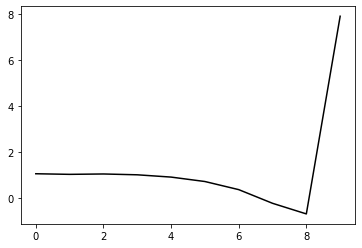

72000 0.2553660262715077
0.2218518620963027 -0.16663710061202394 -0.20432496231270134 -0.12639425826209708
[ 1.08486603  0.99958312  1.00144749  0.97774915  0.9041274   0.74004199
  0.40679104 -0.18312692 -0.65418018  7.94554573]


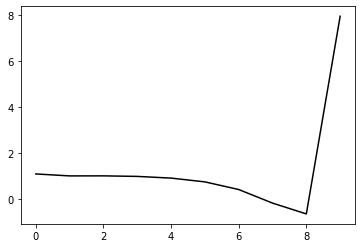

73000 0.23309556213382726
0.21794949188191653 -0.16750533850422208 -0.20445886840445082 -0.12480609646588697
[ 1.06783584  1.08719716  1.04895842  0.98563392  0.90017788  0.74458926
  0.42884536 -0.1480342  -0.61950048  7.93481515]


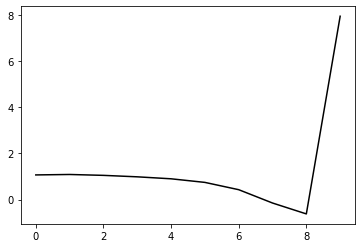

74000 0.18628128472427063
0.22012588602671057 -0.16815503160845283 -0.2056705620398042 -0.1251985690487823
[ 1.07923035  1.06962999  1.0789929   1.03169515  0.92914159  0.74589393
  0.41421215 -0.16596868 -0.64666229  7.93939697]


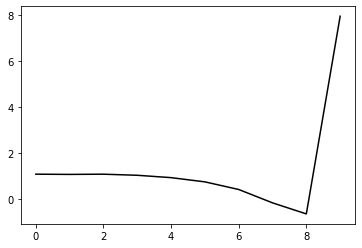

75000 0.25685505289793625
0.2183374852851855 -0.16680392819981396 -0.20530789693539941 -0.12489143417443643
[ 1.08027672  1.06716841  1.05698533  1.02068434  0.94347297  0.78031284
  0.46000675 -0.10610497 -0.57448435  7.97320182]


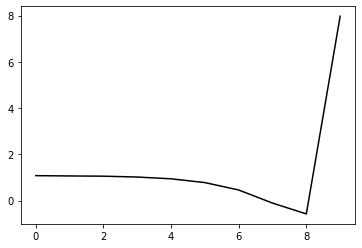

76000 0.18409133584547363
0.21875708471211308 -0.16719510441368027 -0.20588965823909797 -0.12514183966593057
[ 1.06423954  1.02301625  1.02848409  1.00149304  0.91872639  0.75505742
  0.44238273 -0.11662395 -0.5796089   7.94408834]


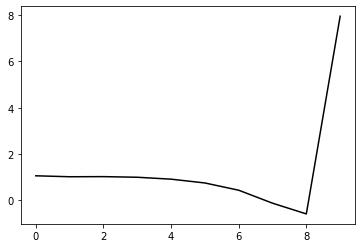

77000 0.2363740592321048
0.2178980327126439 -0.16516606601195807 -0.20298724874041868 -0.1283205879007102
[ 1.06867769  1.03467023  1.02051648  0.96745074  0.87174262  0.69395972
  0.36700133 -0.19809392 -0.66070008  7.92304223]


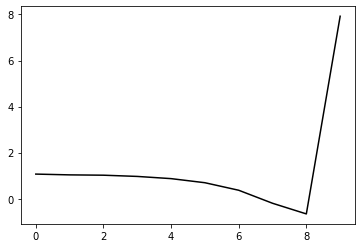

78000 0.19354347284638673
0.22303764948296864 -0.16772422136152984 -0.205883188100572 -0.1278981941308346
[ 1.0571474   1.06100958  1.08760506  1.05319058  0.94826774  0.74848366
  0.3990289  -0.18051735 -0.65027177  7.92833357]


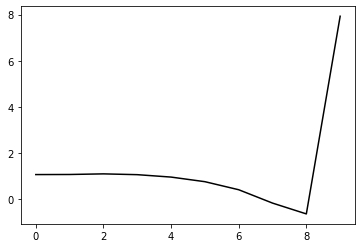

79000 0.22556779856356748
0.22277426031615719 -0.16510434862112935 -0.20364195631751938 -0.12881850159221828
[ 1.06733373  1.06451646  1.06522322  1.01176136  0.90173818  0.69608454
  0.32924273 -0.27122275 -0.75150834  7.87051187]


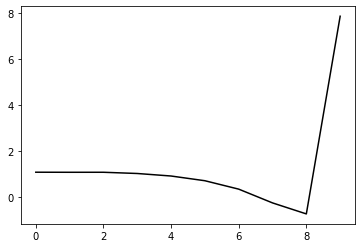

80000 0.23879661685352171
0.22114964421827935 -0.16805236030581155 -0.20656104148342538 -0.12915593768691658
[ 1.06107856  1.03833359  1.03926008  1.00550306  0.92339524  0.74747445
  0.40109593 -0.19556358 -0.67574031  7.9211484 ]


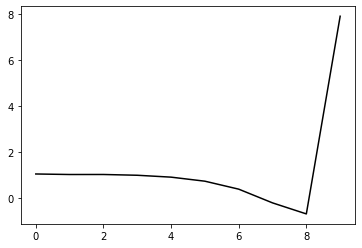

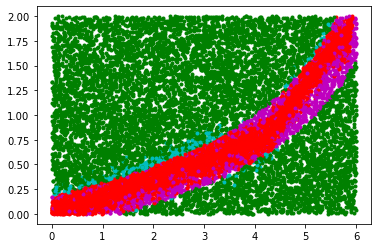

81000 0.26799459376211965
0.22079870041032285 -0.16274141090638836 -0.20358640723911411 -0.1296877577454427
[ 1.0804216   1.12589361  1.09992078  1.02225554  0.91135426  0.73187874
  0.39545792 -0.19967048 -0.68977831  7.91350691]


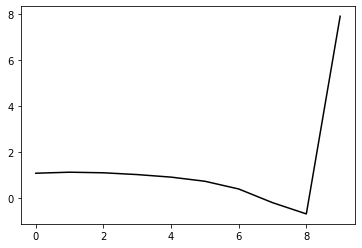

82000 0.3663575872541816
0.2228012261714914 -0.16190004704343497 -0.20446530098652332 -0.12859068996826142
[ 1.08187565  1.06832971  1.0821979   1.04344869  0.94814468  0.76362339
  0.42194297 -0.16847246 -0.6582436   7.90976881]


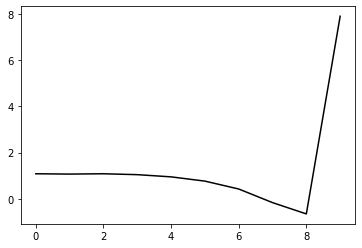

83000 0.23063081855237302
0.22250355007470818 -0.16424732179730495 -0.20700237388426682 -0.12645222687732136
[ 1.08633335  1.0493267   1.05350577  1.00950044  0.91598167  0.73726912
  0.40201089 -0.18207528 -0.66931836  7.93115   ]


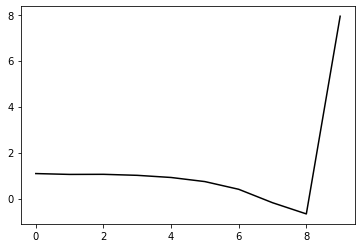

84000 0.22902758878292043
0.21835600197081842 -0.16448148446875446 -0.20615306332287187 -0.12594822613984732
[ 1.05911606  1.0542176   1.02744977  0.99228115  0.90240812  0.71905334
  0.37568427 -0.21716594 -0.71366619  7.91122777]


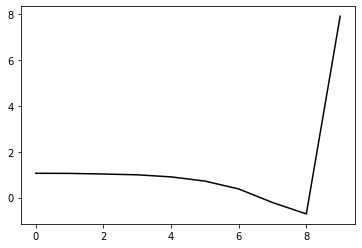

85000 0.17452615776927202
0.2198435582278768 -0.16209720269250627 -0.207182968033811 -0.12257117834007565
[ 1.0984324   1.06586386  1.04451602  0.99761584  0.91976381  0.76381725
  0.44844334 -0.12329076 -0.6052661   7.92637134]


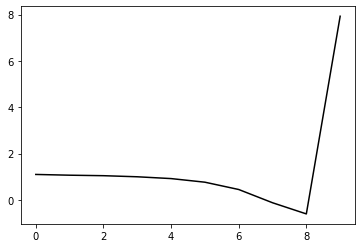

86000 0.11601769004918597
0.21866521791624993 -0.16636389318221995 -0.2089012295481156 -0.12319673071088696
[ 1.07695415  1.11548114  1.11001108  1.05979022  0.94433516  0.7481688
  0.40655964 -0.18053004 -0.67599483  7.91436035]


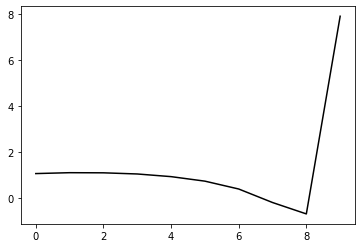

87000 0.1718402186633442
0.221687320607405 -0.1623620036772107 -0.2065524679103386 -0.12352562246787295
[ 1.09558481  1.0642958   1.0678213   1.02945722  0.93697142  0.74862913
  0.3994816  -0.19194414 -0.68539665  7.92268362]


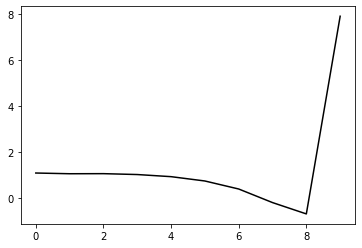

88000 0.2604758488312009
0.2220830201063187 -0.16235274020552562 -0.2071906275442487 -0.1228218567247246
[ 1.09540914  1.08541553  1.1167155   1.1054753   1.02468711  0.82841776
  0.45383744 -0.17208151 -0.69667152  7.93194685]


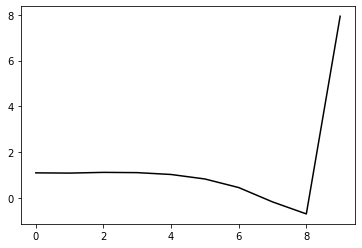

89000 0.20532133607967684
0.21771273376939293 -0.16708107975532224 -0.20873856181489492 -0.11906299451188813
[ 1.03168659  0.95456668  0.93711827  0.90032233  0.79508781  0.59529756
  0.21842749 -0.42622195 -0.9692257   7.89282319]


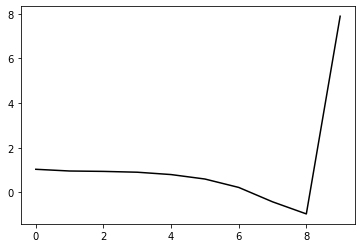

90000 0.268998628059564
0.21927810261247055 -0.1638710053762093 -0.20668562453189457 -0.12693941784679405
[ 1.08142815  1.07921626  1.08298344  1.04452382  0.95677986  0.77125687
  0.4061386  -0.23478748 -0.78194605  7.88713533]


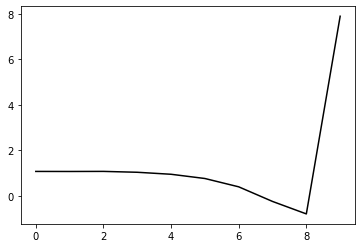

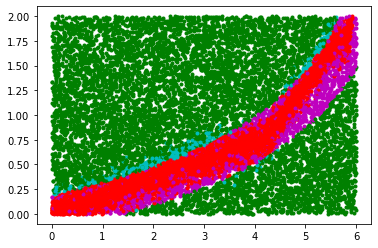

91000 0.1524822658192143
0.21834817447007537 -0.1694976093441082 -0.21014269710875563 -0.12606223189751037
[ 1.04108963  1.00975594  1.00040182  0.95893872  0.87063169  0.68804581
  0.33161497 -0.29902504 -0.83923741  7.89862071]


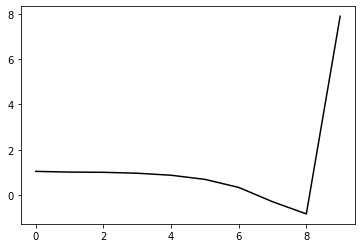

92000 0.18865509856489676
0.21701105511928934 -0.16609385327808276 -0.20777896033349583 -0.12834491024992126
[ 1.06243221  1.06038363  1.04558037  0.99962456  0.91421663  0.74139951
  0.3974725  -0.22110134 -0.75756623  7.89540199]


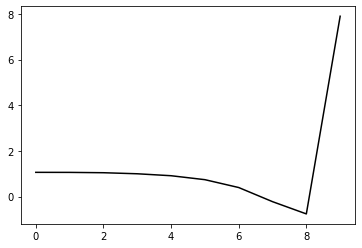

93000 0.30449660426316805
0.21603198826495912 -0.15844698239305555 -0.20338091568234046 -0.12998238857403416
[ 1.05721939  1.11517976  1.1104464   1.05938768  0.96093295  0.77704215
  0.42982848 -0.1885314  -0.73350314  7.8851786 ]


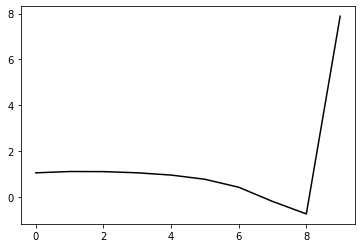

94000 0.24673512833352373
0.21445686480066017 -0.16162767578476486 -0.20681625950246868 -0.12780563925084545
[ 1.0503142   1.04156858  1.04079636  0.98741397  0.89157799  0.71892055
  0.38511717 -0.21762735 -0.75244333  7.91204085]


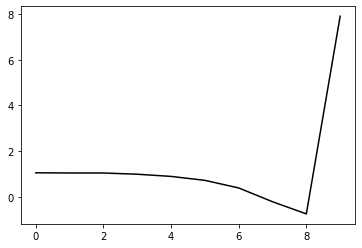

95000 0.20919525449229734
0.21424966390306507 -0.16400798075097117 -0.20731311757250434 -0.1298633068323265
[ 1.06458641  1.05938677  1.05926479  1.01612149  0.91227201  0.71357109
  0.35893756 -0.25295685 -0.79482962  7.90225536]


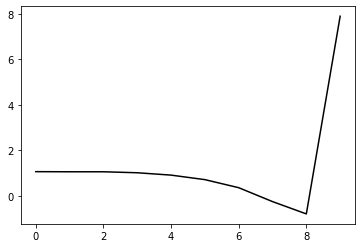

96000 0.1842054000785841
0.21436605331118577 -0.1623764801553019 -0.20765440839374433 -0.1283079525962749
[ 1.05470728  1.03696665  1.05534083  1.03500075  0.96144365  0.78950176
  0.44284061 -0.16699596 -0.704488    7.93717194]


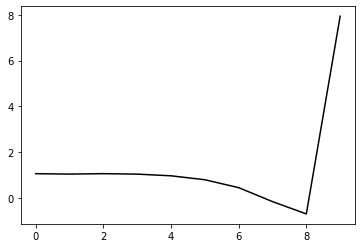

97000 0.2179662989837954
0.213849687953584 -0.15978601686783522 -0.20658387068331585 -0.12579448797808568
[ 1.06775155  1.09400845  1.08899638  1.04296937  0.95721049  0.78781721
  0.45142568 -0.15765507 -0.7014728   7.90054594]


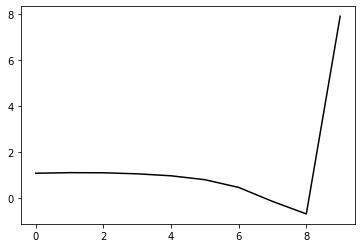

98000 0.24653191177213504
0.21264759717272352 -0.16296940585575836 -0.21072994543942594 -0.12092311098371483
[ 1.05839335  0.98862838  0.97988075  0.96121574  0.89614121  0.74597282
  0.43415549 -0.14923736 -0.67576619  7.94701871]


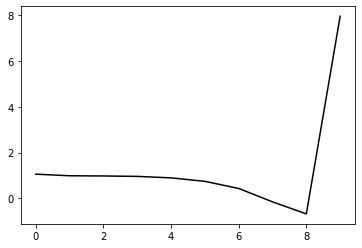

99000 0.22556937888868048
0.2122414103784811 -0.1595091459594136 -0.20770555065462926 -0.12554294298372845
[ 1.0763098   1.06328398  1.04847713  0.9925582   0.90052629  0.73735654
  0.42472147 -0.14958863 -0.66849452  7.92492137]


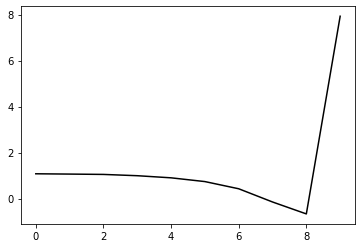

In [18]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
        if np.isnan(loss)==True: break
    for i in range (90):
        optimizer.apply_gradients(zip(gradients, [h]))
        if any(np.isnan(h.numpy()))==True: break
    for i in range (10):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()

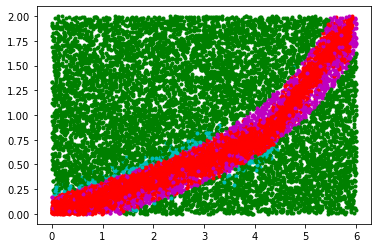

In [21]:
for i in range (set):
    [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
    [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
for i in range (set):
    x_data1[i]=[v[0] for v in Positive0[i]]
    y_data1[i]=[v[1] for v in Positive0[i]]
    x_data2[i]=[v[0] for v in Positive1[i]]
    y_data2[i]=[v[1] for v in Positive1[i]]
    x_data3[i]=[v[0] for v in Negative0[i]]
    y_data3[i]=[v[1] for v in Negative0[i]]
    x_data4[i]=[v[0] for v in Negative1[i]]
    y_data4[i]=[v[1] for v in Negative1[i]]
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()